# Filter Test: DC Offset and Noise Removal

This notebook demonstrates filter testing for DC offset removal and random noise filtering.

## Test Cases

1. **Case 1**: No DC offset
2. **Case 2**: No DC offset + 20 kHz AM modulation on signal 2
3. **Case 3**: No DC offset + 20 kHz AM modulation on signal 2 + random noise
4. **Case 4**: DC offset + 20 kHz AM modulation on signal 2 + random noise
5. **Case 5**: Time-varying DC offset (~kHz waveform) + AM modulation + random noise

## Test Parameters

- Signal frequency: ~10 MHz
- Sampling rate: 100 Msample/s
- Signal duration: 2.5 ms (~250,000 samples)
- Highpass filter cutoff: 1 MHz (for DC removal)
- Bandpass filter bandwidth: 2 MHz around 10 MHz (for noise removal)

## Usage

Run each cell sequentially to explore the filter functionality. Each case can be run independently.

In [1]:
# Setup
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as spsig

# Add project root to path
project_root = Path().resolve().parent.parent.parent
sys.path.insert(0, str(project_root))

from ifi.analysis.phi2ne import PhaseConverter
from ifi.utils.common import LogManager

logger = LogManager().get_logger(__name__)

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Setup complete!")

Setup complete!


## Helper Functions

Define functions for filter creation, signal generation, and analysis.

In [2]:
# HPF creation helper function - uses PhaseConverter._create_hpf directly
def create_highpass_filter(fc: float, fs: float, filter_order: int = None):
    """
    Create a highpass FIR filter using PhaseConverter._create_hpf.
    
    Args:
        fc: Cutoff frequency in Hz (passband edge)
        fs: Sampling frequency in Hz
        filter_order: Maximum number of filter taps. If None, uses automatic design.
        
    Returns:
        FIR filter coefficients (taps) for use with scipy.signal.filtfilt
    """
    phase_converter = PhaseConverter()
    
    # Calculate transition width (10% of cutoff frequency)
    transition_width = fc * 0.1
    f_pass = fc
    f_stop = fc - transition_width
    
    # Ensure f_stop is positive
    nyq = 0.5 * fs
    if f_stop < 0:
        f_stop = 0.01 * nyq  # Small positive value
    
    # Create highpass filter using PhaseConverter method
    taps = phase_converter._create_hpf(
        f_stop=f_stop,
        f_pass=f_pass,
        fs=fs,
        approx=False,
        max_taps=filter_order
    )
    
    return taps

In [3]:
def generate_test_signals(
    fs: float = 100e6,
    duration: float = 2.5e-3,
    f0: float = 10e6,
    case: int = 1,
    dc_offset: float = 0.0,
    noise_level: float = 0.0,
    am_freq: float = 20e3,
    am_depth: float = 0.3,
    dc_offset_waveform: str = None,
    dc_offset_freq: float = 1e3,
    dc_offset_amplitude: float = 1.0,
):
    """
    Generate test signals according to specified case.
    
    Args:
        dc_offset_waveform: Waveform type for time-varying DC offset (case 5).
            Options: 'sine', 'triangle', 'square', 'chirp', or None for constant DC.
        dc_offset_freq: Frequency of time-varying DC offset waveform (Hz).
        dc_offset_amplitude: Amplitude of time-varying DC offset (V).
    
    Returns:
        Tuple of (time_array, signal1, signal2)
        - signal1: Fixed frequency signal (~10 MHz)
        - signal2: Same frequency with time-varying phase
    """
    t = np.arange(0, duration, 1 / fs)
    n_samples = len(t)
    
    # Signal 1: Fixed frequency signal
    signal1 = np.sin(2 * np.pi * f0 * t)
    
    # Signal 2: Same frequency with time-varying phase
    phase_variation = 0.1 * np.sin(2 * np.pi * 1e3 * t) + 0.05 * np.sin(2 * np.pi * 5e3 * t)
    signal2_base = np.sin(2 * np.pi * f0 * t + phase_variation)
    
    # Apply AM modulation for cases 2-5
    if case >= 2:
        am_envelope = 1.0 + am_depth * np.sin(2 * np.pi * am_freq * t)
        signal2_base = signal2_base * am_envelope
    
    # Add random noise for cases 3-5
    if case >= 3:
        noise = np.random.normal(0, noise_level, n_samples)
        signal2_base = signal2_base + noise
    
    # Add DC offset for case 4 (constant)
    if case == 4:
        signal2_base = signal2_base + dc_offset
    
    # Add time-varying DC offset for case 5
    if case == 5:
        if dc_offset_waveform == 'sine':
            dc_varying = dc_offset_amplitude * np.sin(2 * np.pi * dc_offset_freq * t)
        elif dc_offset_waveform == 'triangle':
            # Triangle wave using sawtooth
            dc_varying = dc_offset_amplitude * spsig.sawtooth(2 * np.pi * dc_offset_freq * t, 0.5)
        elif dc_offset_waveform == 'square':
            dc_varying = dc_offset_amplitude * spsig.square(2 * np.pi * dc_offset_freq * t)
        elif dc_offset_waveform == 'chirp':
            # Linear chirp from dc_offset_freq to 2*dc_offset_freq
            dc_varying = dc_offset_amplitude * np.sin(2 * np.pi * (dc_offset_freq * t + dc_offset_freq * t**2 / duration))
        else:
            # Default: sine wave
            dc_varying = dc_offset_amplitude * np.sin(2 * np.pi * dc_offset_freq * t)
        signal2_base = signal2_base + dc_varying
    
    return t, signal1, signal2_base

In [4]:
def analyze_signal_components(signal: np.ndarray, fs: float, f0: float = 10e6):
    """
    Analyze signal components: DC level, noise power, signal power.
    
    Returns:
        Dictionary with analysis results
    """
    # DC component (mean value)
    dc_level = np.mean(signal)
    
    # Remove DC for frequency analysis
    signal_ac = signal - dc_level
    
    # Power spectral density
    freqs, psd = spsig.welch(signal_ac, fs, nperseg=min(8192, len(signal) // 4))
    
    # Signal power around f0 (within 1 MHz bandwidth)
    f_mask = (freqs >= f0 - 0.5e6) & (freqs <= f0 + 0.5e6)
    signal_power = np.trapezoid(psd[f_mask], freqs[f_mask])
    
    # Noise power (outside signal band, up to Nyquist)
    noise_mask = ((freqs >= 0) & (freqs < f0 - 1e6)) | ((freqs > f0 + 1e6) & (freqs <= fs / 2))
    noise_power = np.trapezoid(psd[noise_mask], freqs[noise_mask])
    
    # Total power
    total_power = np.trapezoid(psd, freqs)
    
    return {
        'dc_level': dc_level,
        'signal_power': signal_power,
        'noise_power': noise_power,
        'total_power': total_power,
        'snr_db': 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.inf,
        'freqs': freqs,
        'psd': psd,
    }

## Test Parameters

Configure test parameters here. Modify these values to test different scenarios.

In [5]:
# Test parameters
fs = 100e6  # 100 Msample/s
duration = 2.5e-3  # 2.5 ms
f0 = 10e6  # ~10 MHz carrier frequency
dc_offset = 1.0  # 1 V DC offset for case 4
noise_level = 0.1  # Standard deviation of noise
am_freq = 20e3  # 20 kHz AM modulation frequency
am_depth = 0.3  # 30% AM modulation depth

# Filter parameters
hpf_cutoff = 1e6  # 1 MHz highpass cutoff frequency
bpf_bandwidth = 2e6  # 2 MHz bandwidth around f0 for bandpass filter

print(f"Test Configuration:")
print(f"  Sampling frequency: {fs/1e6:.1f} Msample/s")
print(f"  Signal duration: {duration*1e3:.2f} ms")
print(f"  Carrier frequency: {f0/1e6:.1f} MHz")
print(f"  HPF cutoff: {hpf_cutoff/1e6:.1f} MHz")
print(f"  BPF bandwidth: {bpf_bandwidth/1e6:.1f} MHz")

Test Configuration:
  Sampling frequency: 100.0 Msample/s
  Signal duration: 2.50 ms
  Carrier frequency: 10.0 MHz
  HPF cutoff: 1.0 MHz
  BPF bandwidth: 2.0 MHz


## Case 1: No DC Offset

Test with clean signals - no DC offset, no AM modulation, no noise.

In [6]:
# Generate and test Case 1
case = 1
t, signal1, signal2 = generate_test_signals(
    fs=fs,
    duration=duration,
    f0=f0,
    case=1,
    dc_offset=dc_offset if case >= 4 else 0.0,
    noise_level=noise_level if case >= 3 else 0.0,
    am_freq=am_freq,
    am_depth=am_depth,
)

# Analyze original signal
analysis_before = analyze_signal_components(signal2, fs, f0)

# Apply highpass filter
hpf_taps = create_highpass_filter(hpf_cutoff, fs)
signal_hpf = spsig.filtfilt(hpf_taps, 1.0, signal2)

analysis_after_hpf = analyze_signal_components(signal_hpf, fs, f0)
analysis_after_hpf_only = analysis_after_hpf  # HPF only result

# Apply bandpass filter
phase_converter = PhaseConverter()
bpf_taps = phase_converter._create_bpf(
    f_stop1=f0 - bpf_bandwidth - 0.5e6,
    f_pass1=f0 - bpf_bandwidth / 2,
    f_pass2=f0 + bpf_bandwidth / 2,
    f_stop2=f0 + bpf_bandwidth + 0.5e6,
    fs=fs,
)
signal_bpf = spsig.filtfilt(bpf_taps, 1.0, signal_hpf)
analysis_after_bpf = analyze_signal_components(signal_bpf, fs, f0)

# Also test BPF only (no HPF)
signal_bpf_only = spsig.filtfilt(bpf_taps, 1.0, signal2)
analysis_after_bpf_only = analyze_signal_components(signal_bpf_only, fs, f0)

# Also test BPF -> HPF (order swapped)
signal_bpf_hpf = spsig.filtfilt(hpf_taps, 1.0, signal_bpf_only)
analysis_after_bpf_hpf = analyze_signal_components(signal_bpf_hpf, fs, f0)

results_case1 = {
    'case': case,
    'before': analysis_before,
    'after_hpf': analysis_after_hpf,
    'after_hpf_only': analysis_after_hpf_only,
    'after_bpf': analysis_after_bpf,
    'after_bpf_only': analysis_after_bpf_only,
    'after_bpf_hpf': analysis_after_bpf_hpf,
    'signals': {
        'time': t,
        'original': signal2,
        'hpf_filtered': signal_hpf,       # HPF only
        'bpf_only': signal_bpf_only,       # BPF only
        'bpf_filtered': signal_bpf,        # HPF -> BPF
        'bpf_hpf': signal_bpf_hpf,         # BPF -> HPF
    },
}

print(f"Case {case} Results:")
print(f"  DC Level (before): {analysis_before['dc_level']:.6f} V")
print(f"  DC Level (HPF only): {analysis_after_hpf_only['dc_level']:.6f} V")
print(f"  DC Level (BPF only): {analysis_after_bpf_only['dc_level']:.6f} V")
print(f"  DC Level (HPF->BPF): {analysis_after_bpf['dc_level']:.6f} V")
print(f"  DC Level (BPF->HPF): {analysis_after_bpf_hpf['dc_level']:.6f} V")
print(f"  SNR (before): {analysis_before['snr_db']:.2f} dB")
print(f"  SNR (HPF only): {analysis_after_hpf_only['snr_db']:.2f} dB")
print(f"  SNR (BPF only): {analysis_after_bpf_only['snr_db']:.2f} dB")
print(f"  SNR (HPF->BPF): {analysis_after_bpf['snr_db']:.2f} dB")
print(f"  SNR (BPF->HPF): {analysis_after_bpf_hpf['snr_db']:.2f} dB")

Case 1 Results:
  DC Level (before): -0.000000 V
  DC Level (HPF only): 0.000025 V
  DC Level (BPF only): 0.000002 V
  DC Level (HPF->BPF): 0.000002 V
  DC Level (BPF->HPF): 0.000002 V
  SNR (before): 74.44 dB
  SNR (HPF only): 73.30 dB
  SNR (BPF only): 74.44 dB
  SNR (HPF->BPF): 74.09 dB
  SNR (BPF->HPF): 74.09 dB


## Case 1: BPF Only (No HPF)

Test Case 1 with BPF only (no HPF) to compare the effect of HPF on DC removal.


In [7]:
# Case 1: BPF only (no HPF)
case = 1
t, signal1, signal2 = generate_test_signals(
    fs=fs,
    duration=duration,
    f0=f0,
    case=1,
    dc_offset=dc_offset if case >= 4 else 0.0,
    noise_level=noise_level if case >= 3 else 0.0,
    am_freq=am_freq,
    am_depth=am_depth,
)

# Analyze original signal
analysis_before = analyze_signal_components(signal2, fs, f0)

# Apply bandpass filter only (no HPF)
phase_converter = PhaseConverter()
bpf_taps = phase_converter._create_bpf(
    f_stop1=f0 - bpf_bandwidth - 0.5e6,
    f_pass1=f0 - bpf_bandwidth / 2,
    f_pass2=f0 + bpf_bandwidth / 2,
    f_stop2=f0 + bpf_bandwidth + 0.5e6,
    fs=fs,
)
signal_bpf_only = spsig.filtfilt(bpf_taps, 1.0, signal2)
analysis_after_bpf_only = analyze_signal_components(signal_bpf_only, fs, f0)

results_case1_bpf_only = {
    'case': case,
    'before': analysis_before,
    'after_bpf_only': analysis_after_bpf_only,
    'signals': {
        'time': t,
        'original': signal2,
        'bpf_only': signal_bpf_only,
    },
}

print(f"Case {case} - BPF Only Results:")
print(f"  DC Level (before): {analysis_before['dc_level']:.6f} V")
print(f"  DC Level (after BPF only): {analysis_after_bpf_only['dc_level']:.6f} V")
print(f"  SNR (before): {analysis_before['snr_db']:.2f} dB")
print(f"  SNR (after BPF only): {analysis_after_bpf_only['snr_db']:.2f} dB")
print(f"\nComparison with HPF+BPF:")
print(f"  DC Level (HPF+BPF): {results_case1['after_bpf']['dc_level']:.6f} V")
print(f"  SNR (HPF+BPF): {results_case1['after_bpf']['snr_db']:.2f} dB")


Case 1 - BPF Only Results:
  DC Level (before): -0.000000 V
  DC Level (after BPF only): 0.000002 V
  SNR (before): 74.44 dB
  SNR (after BPF only): 74.44 dB

Comparison with HPF+BPF:
  DC Level (HPF+BPF): 0.000002 V
  SNR (HPF+BPF): 74.09 dB


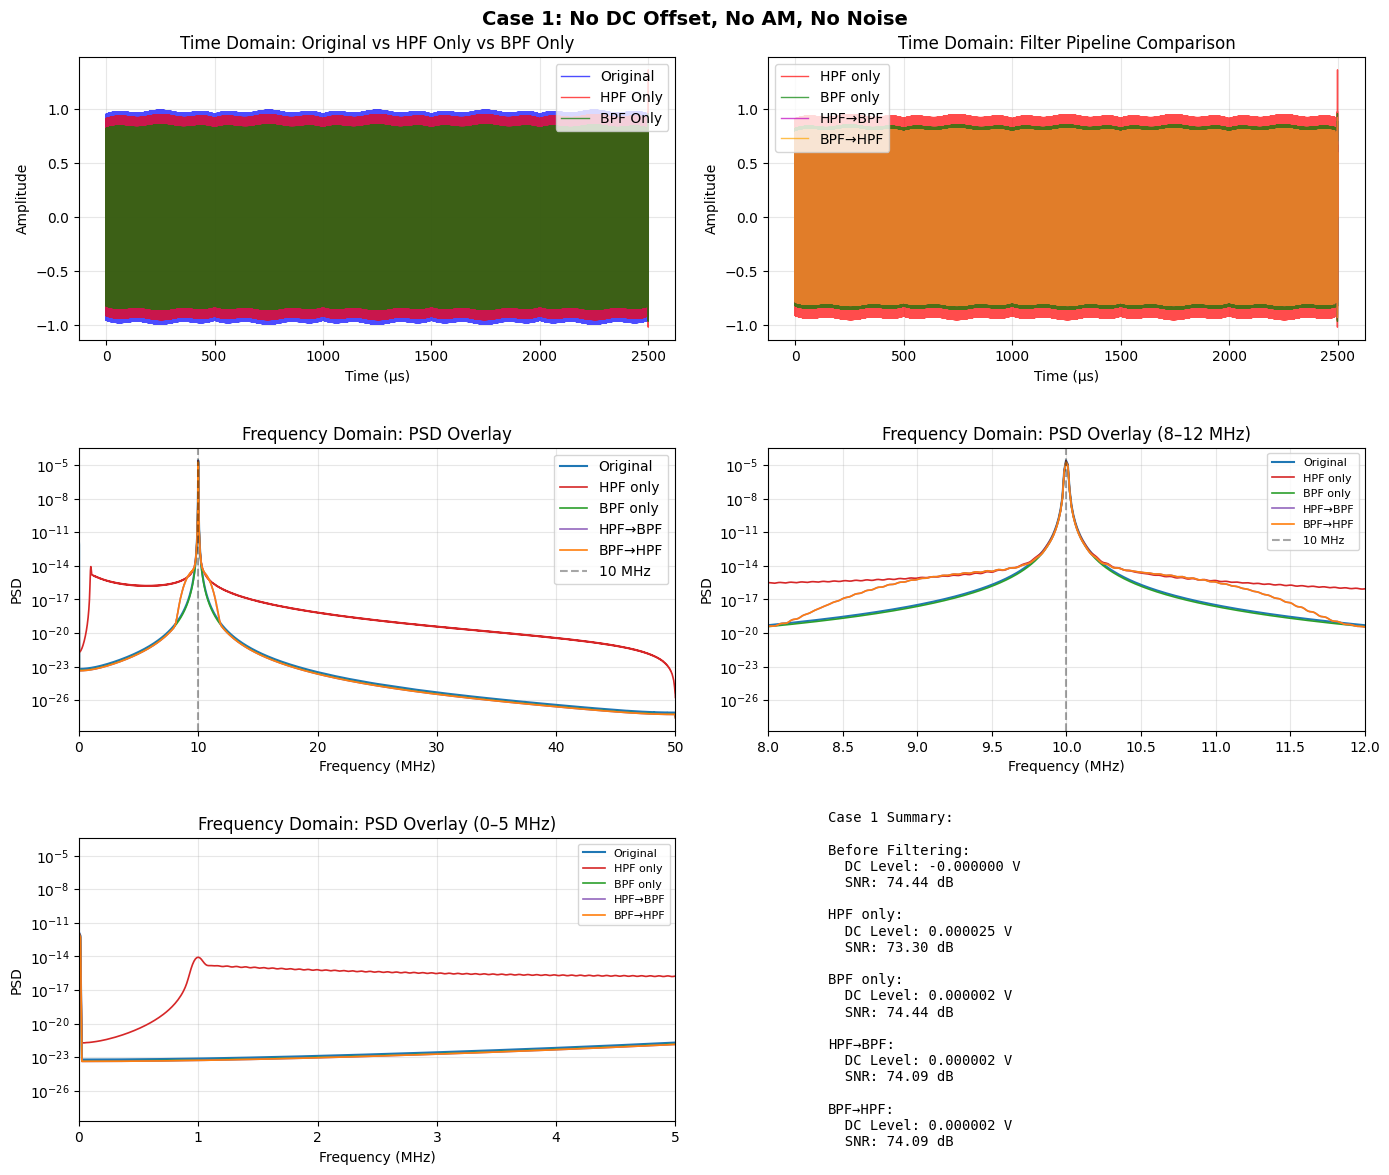

In [8]:
# Visualize Case 1
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle(f'Case 1: No DC Offset, No AM, No Noise', fontsize=14, fontweight='bold')

t_us = results_case1['signals']['time'] * 1e6

# Time domain: Original vs HPF Only vs BPF Only
ax = axes[0, 0]
ax.plot(t_us, results_case1['signals']['original'], 'b-', alpha=0.7, label='Original', linewidth=1)
ax.plot(t_us, results_case1['signals']['hpf_filtered'], 'r-', alpha=0.7, label='HPF Only', linewidth=1)
ax.plot(t_us, results_case1['signals']['bpf_only'], 'g-', alpha=0.7, label='BPF Only', linewidth=1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Original vs HPF Only vs BPF Only')
ax.legend()
ax.grid(True, alpha=0.3)

# Time domain: HPF only vs BPF only vs HPF→BPF vs BPF→HPF
ax = axes[0, 1]
ax.plot(t_us, results_case1['signals']['hpf_filtered'], 'r-', alpha=0.7, label='HPF only', linewidth=1)
ax.plot(t_us, results_case1['signals']['bpf_only'], 'g-', alpha=0.7, label='BPF only', linewidth=1)
ax.plot(t_us, results_case1['signals']['bpf_filtered'], 'm-', alpha=0.7, label='HPF→BPF', linewidth=1)
ax.plot(t_us, results_case1['signals']['bpf_hpf'], color='orange', alpha=0.7, label='BPF→HPF', linewidth=1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Filter Pipeline Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Frequency domain: PSD overlay (all pipelines)
ax = axes[1, 0]
freqs_mhz = results_case1['before']['freqs'] / 1e6
ax.semilogy(freqs_mhz, results_case1['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case1['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case1['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case1['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case1['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay')
ax.set_xlim(0, 50)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.legend()

# Frequency domain: PSD overlay (zoom near carrier)
ax = axes[1, 1]
ax.semilogy(freqs_mhz, results_case1['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case1['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case1['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case1['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case1['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (8–12 MHz)')
ax.set_xlim(8, 12)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.legend(fontsize=8)

# Frequency domain: PSD overlay (zoom low frequency / DC)
ax = axes[2, 0]
ax.semilogy(freqs_mhz, results_case1['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case1['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case1['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case1['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case1['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (0–5 MHz)')
ax.set_xlim(0, 5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Summary statistics
ax = axes[2, 1]
ax.axis('off')
summary_text = f"""
Case 1 Summary:

Before Filtering:
  DC Level: {results_case1['before']['dc_level']:.6f} V
  SNR: {results_case1['before']['snr_db']:.2f} dB

HPF only:
  DC Level: {results_case1['after_hpf_only']['dc_level']:.6f} V
  SNR: {results_case1['after_hpf_only']['snr_db']:.2f} dB

BPF only:
  DC Level: {results_case1['after_bpf_only']['dc_level']:.6f} V
  SNR: {results_case1['after_bpf_only']['snr_db']:.2f} dB

HPF→BPF:
  DC Level: {results_case1['after_bpf']['dc_level']:.6f} V
  SNR: {results_case1['after_bpf']['snr_db']:.2f} dB

BPF→HPF:
  DC Level: {results_case1['after_bpf_hpf']['dc_level']:.6f} V
  SNR: {results_case1['after_bpf_hpf']['snr_db']:.2f} dB
"""
ax.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
        verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

## Case 2: AM Modulation (No DC, No Noise)

Test with 20 kHz on signal 2, but no DC offset or noise.

In [9]:
# Generate and test Case 2
case = 2
t, signal1, signal2 = generate_test_signals(
    fs=fs,
    duration=duration,
    f0=f0,
    case=2,
    dc_offset=dc_offset if case >= 4 else 0.0,
    noise_level=noise_level if case >= 3 else 0.0,
    am_freq=am_freq,
    am_depth=am_depth,
)

# Analyze original signal
analysis_before = analyze_signal_components(signal2, fs, f0)

# Apply highpass filter
hpf_taps = create_highpass_filter(hpf_cutoff, fs)
signal_hpf = spsig.filtfilt(hpf_taps, 1.0, signal2)

analysis_after_hpf = analyze_signal_components(signal_hpf, fs, f0)
analysis_after_hpf_only = analysis_after_hpf  # HPF only result

# Apply bandpass filter
phase_converter = PhaseConverter()
bpf_taps = phase_converter._create_bpf(
    f_stop1=f0 - bpf_bandwidth - 0.5e6,
    f_pass1=f0 - bpf_bandwidth / 2,
    f_pass2=f0 + bpf_bandwidth / 2,
    f_stop2=f0 + bpf_bandwidth + 0.5e6,
    fs=fs,
)
signal_bpf = spsig.filtfilt(bpf_taps, 1.0, signal_hpf)
analysis_after_bpf = analyze_signal_components(signal_bpf, fs, f0)

# Also test BPF only (no HPF)
signal_bpf_only = spsig.filtfilt(bpf_taps, 1.0, signal2)
analysis_after_bpf_only = analyze_signal_components(signal_bpf_only, fs, f0)

# Also test BPF -> HPF (order swapped)
signal_bpf_hpf = spsig.filtfilt(hpf_taps, 1.0, signal_bpf_only)
analysis_after_bpf_hpf = analyze_signal_components(signal_bpf_hpf, fs, f0)

results_case2 = {
    'case': case,
    'before': analysis_before,
    'after_hpf': analysis_after_hpf,
    'after_hpf_only': analysis_after_hpf_only,
    'after_bpf': analysis_after_bpf,
    'after_bpf_only': analysis_after_bpf_only,
    'after_bpf_hpf': analysis_after_bpf_hpf,
    'signals': {
        'time': t,
        'original': signal2,
        'hpf_filtered': signal_hpf,      # HPF only
        'bpf_only': signal_bpf_only,      # BPF only
        'bpf_filtered': signal_bpf,       # HPF -> BPF
        'bpf_hpf': signal_bpf_hpf,        # BPF -> HPF
    },
}

print(f"Case {case} Results:")
print(f"  DC Level (before): {analysis_before['dc_level']:.6f} V")
print(f"  DC Level (HPF only): {analysis_after_hpf_only['dc_level']:.6f} V")
print(f"  DC Level (BPF only): {analysis_after_bpf_only['dc_level']:.6f} V")
print(f"  DC Level (HPF->BPF): {analysis_after_bpf['dc_level']:.6f} V")
print(f"  DC Level (BPF->HPF): {analysis_after_bpf_hpf['dc_level']:.6f} V")
print(f"  SNR (before): {analysis_before['snr_db']:.2f} dB")
print(f"  SNR (HPF only): {analysis_after_hpf_only['snr_db']:.2f} dB")
print(f"  SNR (BPF only): {analysis_after_bpf_only['snr_db']:.2f} dB")
print(f"  SNR (HPF->BPF): {analysis_after_bpf['snr_db']:.2f} dB")
print(f"  SNR (BPF->HPF): {analysis_after_bpf_hpf['snr_db']:.2f} dB")

Case 2 Results:
  DC Level (before): -0.000000 V
  DC Level (HPF only): 0.000025 V
  DC Level (BPF only): 0.000002 V
  DC Level (HPF->BPF): 0.000002 V
  DC Level (BPF->HPF): 0.000002 V
  SNR (before): 74.29 dB
  SNR (HPF only): 73.19 dB
  SNR (BPF only): 74.29 dB
  SNR (HPF->BPF): 73.92 dB
  SNR (BPF->HPF): 73.92 dB


C:\Users\dhkdw\AppData\Local\Temp\ipykernel_43112\923178156.py:110: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


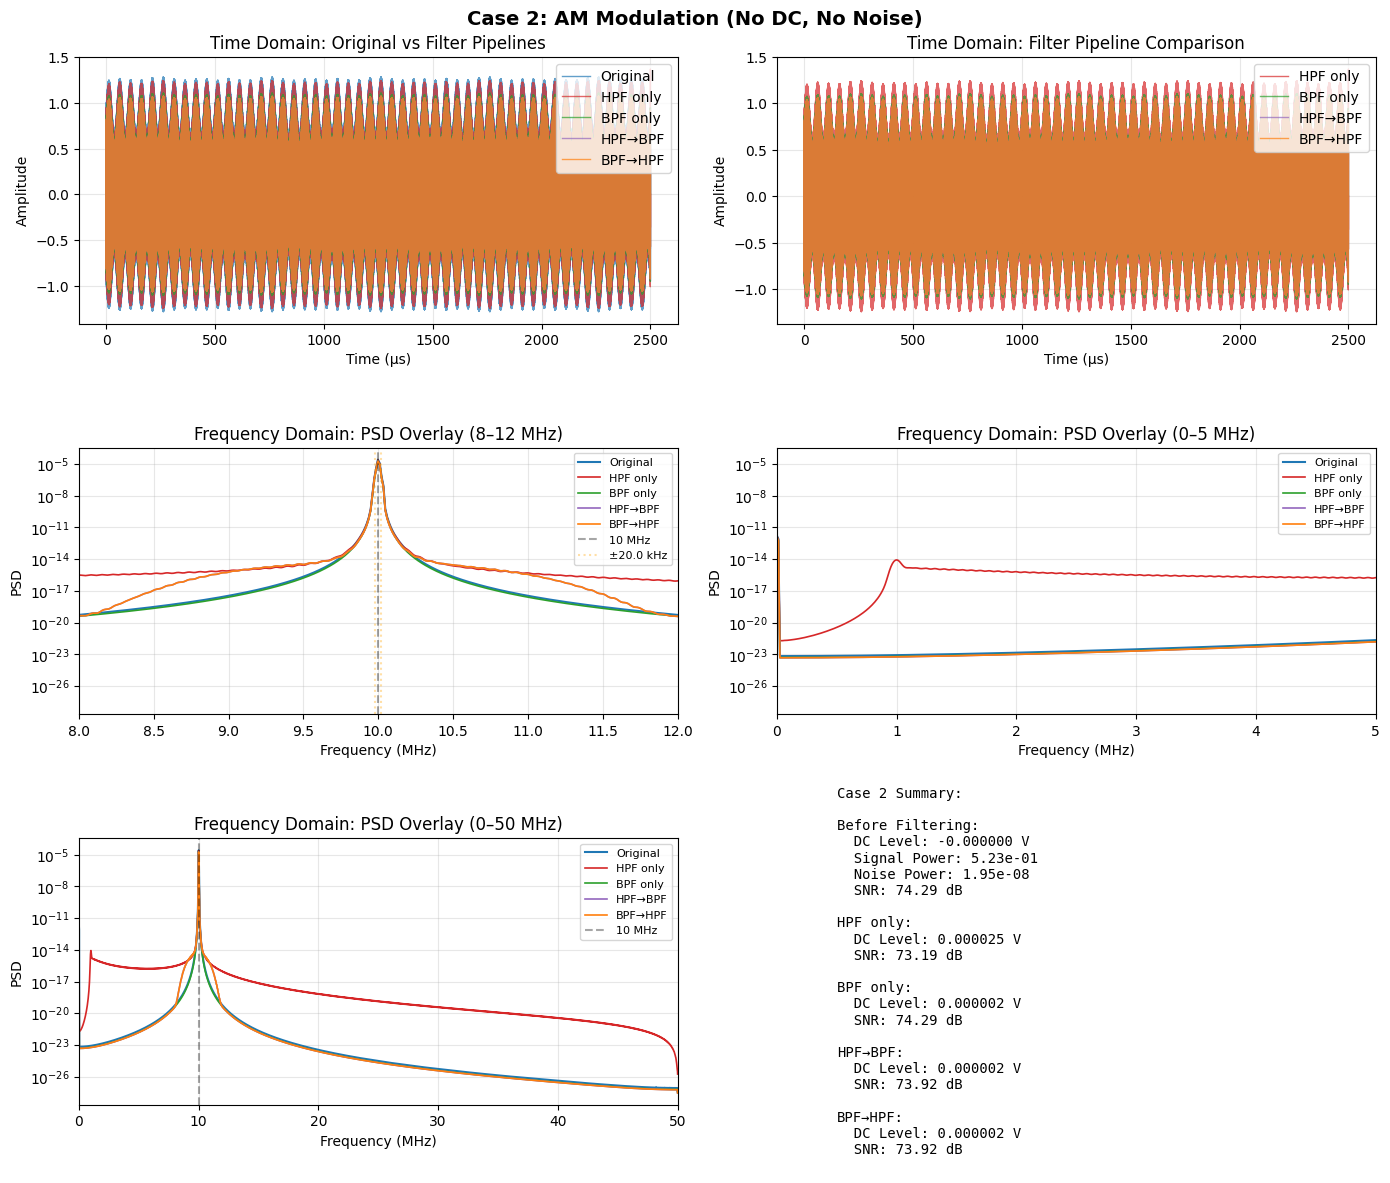

In [10]:
# Visualize Case 2
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle(f'Case 2: AM Modulation (No DC, No Noise)', fontsize=14, fontweight='bold')

t_us = results_case2['signals']['time'] * 1e6

# Time domain: Original vs pipelines
ax = axes[0, 0]
ax.plot(t_us, results_case2['signals']['original'], color='C0', alpha=0.7, label='Original', linewidth=1)
ax.plot(t_us, results_case2['signals']['hpf_filtered'], color='C3', alpha=0.7, label='HPF only', linewidth=1)
ax.plot(t_us, results_case2['signals']['bpf_only'], color='C2', alpha=0.7, label='BPF only', linewidth=1)
ax.plot(t_us, results_case2['signals']['bpf_filtered'], color='C4', alpha=0.7, label='HPF→BPF', linewidth=1)
ax.plot(t_us, results_case2['signals']['bpf_hpf'], color='C1', alpha=0.7, label='BPF→HPF', linewidth=1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Original vs Filter Pipelines')
ax.legend()
ax.grid(True, alpha=0.3)

# Time domain: pipelines only
ax = axes[0, 1]
ax.plot(t_us, results_case2['signals']['hpf_filtered'], color='C3', alpha=0.7, label='HPF only', linewidth=1)
ax.plot(t_us, results_case2['signals']['bpf_only'], color='C2', alpha=0.7, label='BPF only', linewidth=1)
ax.plot(t_us, results_case2['signals']['bpf_filtered'], color='C4', alpha=0.7, label='HPF→BPF', linewidth=1)
ax.plot(t_us, results_case2['signals']['bpf_hpf'], color='C1', alpha=0.7, label='BPF→HPF', linewidth=1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Filter Pipeline Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Frequency domain: PSD overlay near carrier (AM sidebands)
ax = axes[1, 0]
freqs_mhz = results_case2['before']['freqs'] / 1e6
ax.semilogy(freqs_mhz, results_case2['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case2['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case2['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case2['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case2['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (8–12 MHz)')
ax.set_xlim(8, 12)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.axvline(10 - am_freq/1e6, color='orange', linestyle=':', alpha=0.35, label=f'±{am_freq/1e3:.1f} kHz')
ax.axvline(10 + am_freq/1e6, color='orange', linestyle=':', alpha=0.35)
ax.legend(fontsize=8)

# Frequency domain: PSD overlay (low frequency / DC)
ax = axes[1, 1]
ax.semilogy(freqs_mhz, results_case2['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case2['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case2['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case2['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case2['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (0–5 MHz)')
ax.set_xlim(0, 5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Frequency domain: PSD overlay (full)
ax = axes[2, 0]
ax.semilogy(freqs_mhz, results_case2['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case2['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case2['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case2['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case2['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (0–50 MHz)')
ax.set_xlim(0, 50)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.legend(fontsize=8)

# Summary statistics
ax = axes[2, 1]
ax.axis('off')
summary_text = f"""
Case 2 Summary:

Before Filtering:
  DC Level: {results_case2['before']['dc_level']:.6f} V
  Signal Power: {results_case2['before']['signal_power']:.2e}
  Noise Power: {results_case2['before']['noise_power']:.2e}
  SNR: {results_case2['before']['snr_db']:.2f} dB

HPF only:
  DC Level: {results_case2['after_hpf_only']['dc_level']:.6f} V
  SNR: {results_case2['after_hpf_only']['snr_db']:.2f} dB

BPF only:
  DC Level: {results_case2['after_bpf_only']['dc_level']:.6f} V
  SNR: {results_case2['after_bpf_only']['snr_db']:.2f} dB

HPF→BPF:
  DC Level: {results_case2['after_bpf']['dc_level']:.6f} V
  SNR: {results_case2['after_bpf']['snr_db']:.2f} dB

BPF→HPF:
  DC Level: {results_case2['after_bpf_hpf']['dc_level']:.6f} V
  SNR: {results_case2['after_bpf_hpf']['snr_db']:.2f} dB
"""
ax.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
        verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

## Case 3: AM Modulation + Random Noise (No DC)

Test with AM modulation and random noise, but no DC offset.

In [11]:
# Generate and test Case 3
case = 3
t, signal1, signal2 = generate_test_signals(
    fs=fs,
    duration=duration,
    f0=f0,
    case=3,
    dc_offset=dc_offset if case >= 4 else 0.0,
    noise_level=noise_level if case >= 3 else 0.0,
    am_freq=am_freq,
    am_depth=am_depth,
)

# Analyze original signal
analysis_before = analyze_signal_components(signal2, fs, f0)

# Apply highpass filter
hpf_taps = create_highpass_filter(hpf_cutoff, fs)
signal_hpf = spsig.filtfilt(hpf_taps, 1.0, signal2)

analysis_after_hpf = analyze_signal_components(signal_hpf, fs, f0)
analysis_after_hpf_only = analysis_after_hpf  # HPF only result

# Apply bandpass filter
phase_converter = PhaseConverter()
bpf_taps = phase_converter._create_bpf(
    f_stop1=f0 - bpf_bandwidth - 0.5e6,
    f_pass1=f0 - bpf_bandwidth / 2,
    f_pass2=f0 + bpf_bandwidth / 2,
    f_stop2=f0 + bpf_bandwidth + 0.5e6,
    fs=fs,
)
signal_bpf = spsig.filtfilt(bpf_taps, 1.0, signal_hpf)
analysis_after_bpf = analyze_signal_components(signal_bpf, fs, f0)

# Also test BPF only (no HPF)
signal_bpf_only = spsig.filtfilt(bpf_taps, 1.0, signal2)
analysis_after_bpf_only = analyze_signal_components(signal_bpf_only, fs, f0)

# Also test BPF -> HPF (order swapped)
signal_bpf_hpf = spsig.filtfilt(hpf_taps, 1.0, signal_bpf_only)
analysis_after_bpf_hpf = analyze_signal_components(signal_bpf_hpf, fs, f0)

results_case3 = {
    'case': case,
    'before': analysis_before,
    'after_hpf': analysis_after_hpf,
    'after_hpf_only': analysis_after_hpf_only,
    'after_bpf': analysis_after_bpf,
    'after_bpf_only': analysis_after_bpf_only,
    'after_bpf_hpf': analysis_after_bpf_hpf,
    'signals': {
        'time': t,
        'original': signal2,
        'hpf_filtered': signal_hpf,      # HPF only
        'bpf_only': signal_bpf_only,      # BPF only
        'bpf_filtered': signal_bpf,       # HPF -> BPF
        'bpf_hpf': signal_bpf_hpf,        # BPF -> HPF
    },
}

print(f"Case {case} Results:")
print(f"  DC Level (before): {analysis_before['dc_level']:.6f} V")
print(f"  DC Level (HPF only): {analysis_after_hpf_only['dc_level']:.6f} V")
print(f"  DC Level (BPF only): {analysis_after_bpf_only['dc_level']:.6f} V")
print(f"  DC Level (HPF->BPF): {analysis_after_bpf['dc_level']:.6f} V")
print(f"  DC Level (BPF->HPF): {analysis_after_bpf_hpf['dc_level']:.6f} V")
print(f"  SNR (before): {analysis_before['snr_db']:.2f} dB")
print(f"  SNR (HPF only): {analysis_after_hpf_only['snr_db']:.2f} dB")
print(f"  SNR (BPF only): {analysis_after_bpf_only['snr_db']:.2f} dB")
print(f"  SNR (HPF->BPF): {analysis_after_bpf['snr_db']:.2f} dB")
print(f"  SNR (BPF->HPF): {analysis_after_bpf_hpf['snr_db']:.2f} dB")

Case 3 Results:
  DC Level (before): -0.000090 V
  DC Level (HPF only): 0.000022 V
  DC Level (BPF only): 0.000002 V
  DC Level (HPF->BPF): 0.000002 V
  DC Level (BPF->HPF): 0.000002 V
  SNR (before): 17.15 dB
  SNR (HPF only): 16.87 dB
  SNR (BPF only): 30.11 dB
  SNR (HPF->BPF): 29.84 dB
  SNR (BPF->HPF): 29.84 dB


c:\Users\dhkdw\Documents\mygit\ifi\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


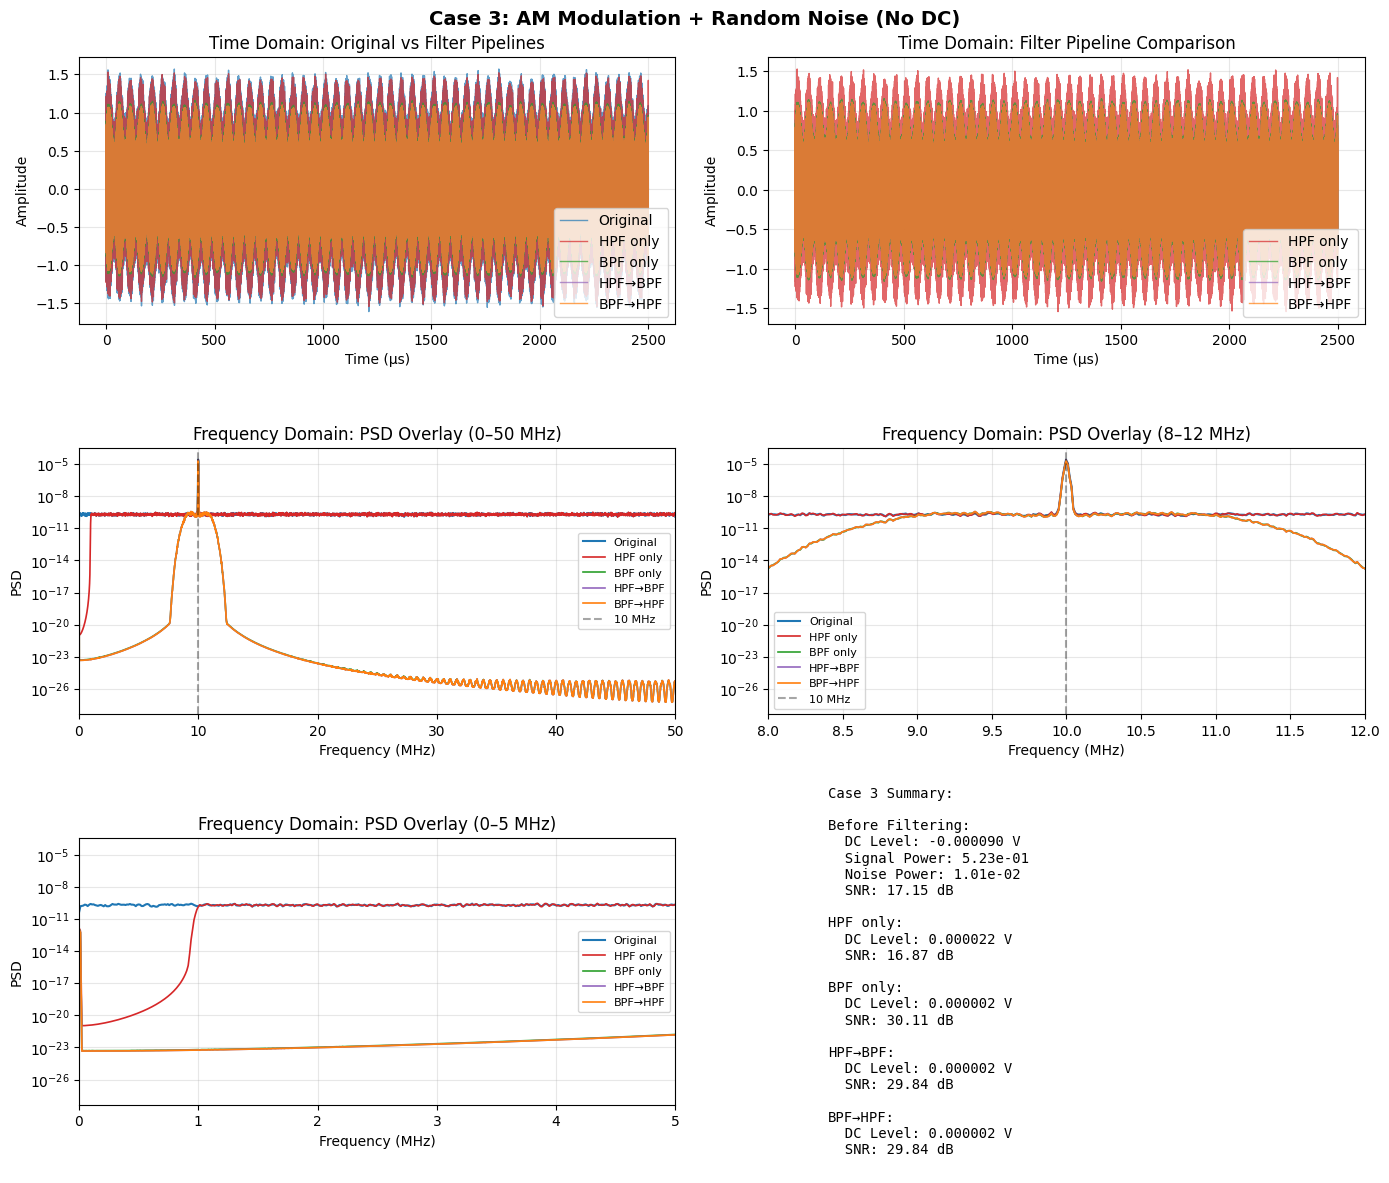

In [12]:
# Visualize Case 3
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle(f'Case 3: AM Modulation + Random Noise (No DC)', fontsize=14, fontweight='bold')

t_us = results_case3['signals']['time'] * 1e6

# Time domain: Original vs pipelines
ax = axes[0, 0]
ax.plot(t_us, results_case3['signals']['original'], color='C0', alpha=0.7, label='Original', linewidth=1)
ax.plot(t_us, results_case3['signals']['hpf_filtered'], color='C3', alpha=0.7, label='HPF only', linewidth=1)
ax.plot(t_us, results_case3['signals']['bpf_only'], color='C2', alpha=0.7, label='BPF only', linewidth=1)
ax.plot(t_us, results_case3['signals']['bpf_filtered'], color='C4', alpha=0.7, label='HPF→BPF', linewidth=1)
ax.plot(t_us, results_case3['signals']['bpf_hpf'], color='C1', alpha=0.7, label='BPF→HPF', linewidth=1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Original vs Filter Pipelines')
ax.legend()
ax.grid(True, alpha=0.3)

# Time domain: pipelines only
ax = axes[0, 1]
ax.plot(t_us, results_case3['signals']['hpf_filtered'], color='C3', alpha=0.7, label='HPF only', linewidth=1)
ax.plot(t_us, results_case3['signals']['bpf_only'], color='C2', alpha=0.7, label='BPF only', linewidth=1)
ax.plot(t_us, results_case3['signals']['bpf_filtered'], color='C4', alpha=0.7, label='HPF→BPF', linewidth=1)
ax.plot(t_us, results_case3['signals']['bpf_hpf'], color='C1', alpha=0.7, label='BPF→HPF', linewidth=1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Filter Pipeline Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Frequency domain: PSD overlay (full)
ax = axes[1, 0]
freqs_mhz = results_case3['before']['freqs'] / 1e6
ax.semilogy(freqs_mhz, results_case3['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case3['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case3['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case3['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case3['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (0–50 MHz)')
ax.set_xlim(0, 50)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.legend(fontsize=8)

# Frequency domain: PSD overlay (zoom near carrier)
ax = axes[1, 1]
ax.semilogy(freqs_mhz, results_case3['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case3['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case3['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case3['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case3['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (8–12 MHz)')
ax.set_xlim(8, 12)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.legend(fontsize=8)

# Frequency domain: PSD overlay (low frequency / DC)
ax = axes[2, 0]
ax.semilogy(freqs_mhz, results_case3['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case3['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case3['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case3['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case3['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (0–5 MHz)')
ax.set_xlim(0, 5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Summary statistics
ax = axes[2, 1]
ax.axis('off')
summary_text = f"""
Case 3 Summary:

Before Filtering:
  DC Level: {results_case3['before']['dc_level']:.6f} V
  Signal Power: {results_case3['before']['signal_power']:.2e}
  Noise Power: {results_case3['before']['noise_power']:.2e}
  SNR: {results_case3['before']['snr_db']:.2f} dB

HPF only:
  DC Level: {results_case3['after_hpf_only']['dc_level']:.6f} V
  SNR: {results_case3['after_hpf_only']['snr_db']:.2f} dB

BPF only:
  DC Level: {results_case3['after_bpf_only']['dc_level']:.6f} V
  SNR: {results_case3['after_bpf_only']['snr_db']:.2f} dB

HPF→BPF:
  DC Level: {results_case3['after_bpf']['dc_level']:.6f} V
  SNR: {results_case3['after_bpf']['snr_db']:.2f} dB

BPF→HPF:
  DC Level: {results_case3['after_bpf_hpf']['dc_level']:.6f} V
  SNR: {results_case3['after_bpf_hpf']['snr_db']:.2f} dB
"""
ax.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
        verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

## Case 5: Time-Varying DC Offset + AM Modulation + Random Noise

Test with time-varying DC offset (kHz frequency waveform), AM modulation, and random noise.
This tests HPF's ability to remove low-frequency DC variations.


In [13]:
# Generate and test Case 5
case = 5
dc_offset_freq = 5e3  # 5 kHz varying DC offset
dc_offset_amplitude = 1.0  # 1 V amplitude
dc_offset_waveform = 'sine'  # Options: 'sine', 'triangle', 'square', 'chirp'

t, signal1, signal2 = generate_test_signals(
    fs=fs,
    duration=duration,
    f0=f0,
    case=5,
    dc_offset=dc_offset if case >= 4 else 0.0,
    noise_level=noise_level if case >= 3 else 0.0,
    am_freq=am_freq,
    am_depth=am_depth,
    dc_offset_waveform=dc_offset_waveform,
    dc_offset_freq=dc_offset_freq,
    dc_offset_amplitude=dc_offset_amplitude,
)

# Analyze original signal
analysis_before = analyze_signal_components(signal2, fs, f0)

# Apply highpass filter
hpf_taps = create_highpass_filter(hpf_cutoff, fs)
signal_hpf = spsig.filtfilt(hpf_taps, 1.0, signal2)

analysis_after_hpf = analyze_signal_components(signal_hpf, fs, f0)

# Apply bandpass filter
phase_converter = PhaseConverter()
bpf_taps = phase_converter._create_bpf(
    f_stop1=f0 - bpf_bandwidth - 0.5e6,
    f_pass1=f0 - bpf_bandwidth / 2,
    f_pass2=f0 + bpf_bandwidth / 2,
    f_stop2=f0 + bpf_bandwidth + 0.5e6,
    fs=fs,
)
signal_bpf = spsig.filtfilt(bpf_taps, 1.0, signal_hpf)
analysis_after_bpf = analyze_signal_components(signal_bpf, fs, f0)

# Also test BPF only (no HPF)
signal_bpf_only = spsig.filtfilt(bpf_taps, 1.0, signal2)
analysis_after_bpf_only = analyze_signal_components(signal_bpf_only, fs, f0)

# Also test BPF -> HPF (order swapped)
signal_bpf_hpf = spsig.filtfilt(hpf_taps, 1.0, signal_bpf_only)
analysis_after_bpf_hpf = analyze_signal_components(signal_bpf_hpf, fs, f0)

# Also test HPF only (no BPF)
analysis_after_hpf_only = analyze_signal_components(signal_hpf, fs, f0)

results_case5 = {
    'case': case,
    'before': analysis_before,
    'after_hpf': analysis_after_hpf,
    'after_hpf_only': analysis_after_hpf_only,
    'after_bpf': analysis_after_bpf,
    'after_bpf_only': analysis_after_bpf_only,
    'after_bpf_hpf': analysis_after_bpf_hpf,
    'signals': {
        'time': t,
        'original': signal2,
        'hpf_filtered': signal_hpf,      # HPF only
        'bpf_only': signal_bpf_only,      # BPF only
        'bpf_filtered': signal_bpf,       # HPF -> BPF
        'bpf_hpf': signal_bpf_hpf,        # BPF -> HPF
    },
    'dc_offset_params': {
        'waveform': dc_offset_waveform,
        'freq': dc_offset_freq,
        'amplitude': dc_offset_amplitude,
    },
}

print(f"Case {case} Results:")
print(f"  DC Offset Waveform: {dc_offset_waveform} at {dc_offset_freq/1e3:.1f} kHz, amplitude {dc_offset_amplitude:.2f} V")
print(f"  DC Level (before): {analysis_before['dc_level']:.6f} V")
print(f"  DC Level (HPF only): {analysis_after_hpf_only['dc_level']:.6f} V")
print(f"  DC Level (BPF only): {analysis_after_bpf_only['dc_level']:.6f} V")
print(f"  DC Level (HPF->BPF): {analysis_after_bpf['dc_level']:.6f} V")
print(f"  DC Level (BPF->HPF): {analysis_after_bpf_hpf['dc_level']:.6f} V")
print(f"  SNR (before): {analysis_before['snr_db']:.2f} dB")
print(f"  SNR (HPF only): {analysis_after_hpf_only['snr_db']:.2f} dB")
print(f"  SNR (BPF only): {analysis_after_bpf_only['snr_db']:.2f} dB")
print(f"  SNR (HPF->BPF): {analysis_after_bpf['snr_db']:.2f} dB")
print(f"  SNR (BPF->HPF): {analysis_after_bpf_hpf['snr_db']:.2f} dB")


Case 5 Results:
  DC Offset Waveform: sine at 5.0 kHz, amplitude 1.00 V
  DC Level (before): 0.025380 V
  DC Level (HPF only): 0.000026 V
  DC Level (BPF only): 0.000002 V
  DC Level (HPF->BPF): 0.000002 V
  DC Level (BPF->HPF): 0.000002 V
  SNR (before): 7.85 dB
  SNR (HPF only): 16.90 dB
  SNR (BPF only): 30.25 dB
  SNR (HPF->BPF): 30.02 dB
  SNR (BPF->HPF): 30.02 dB


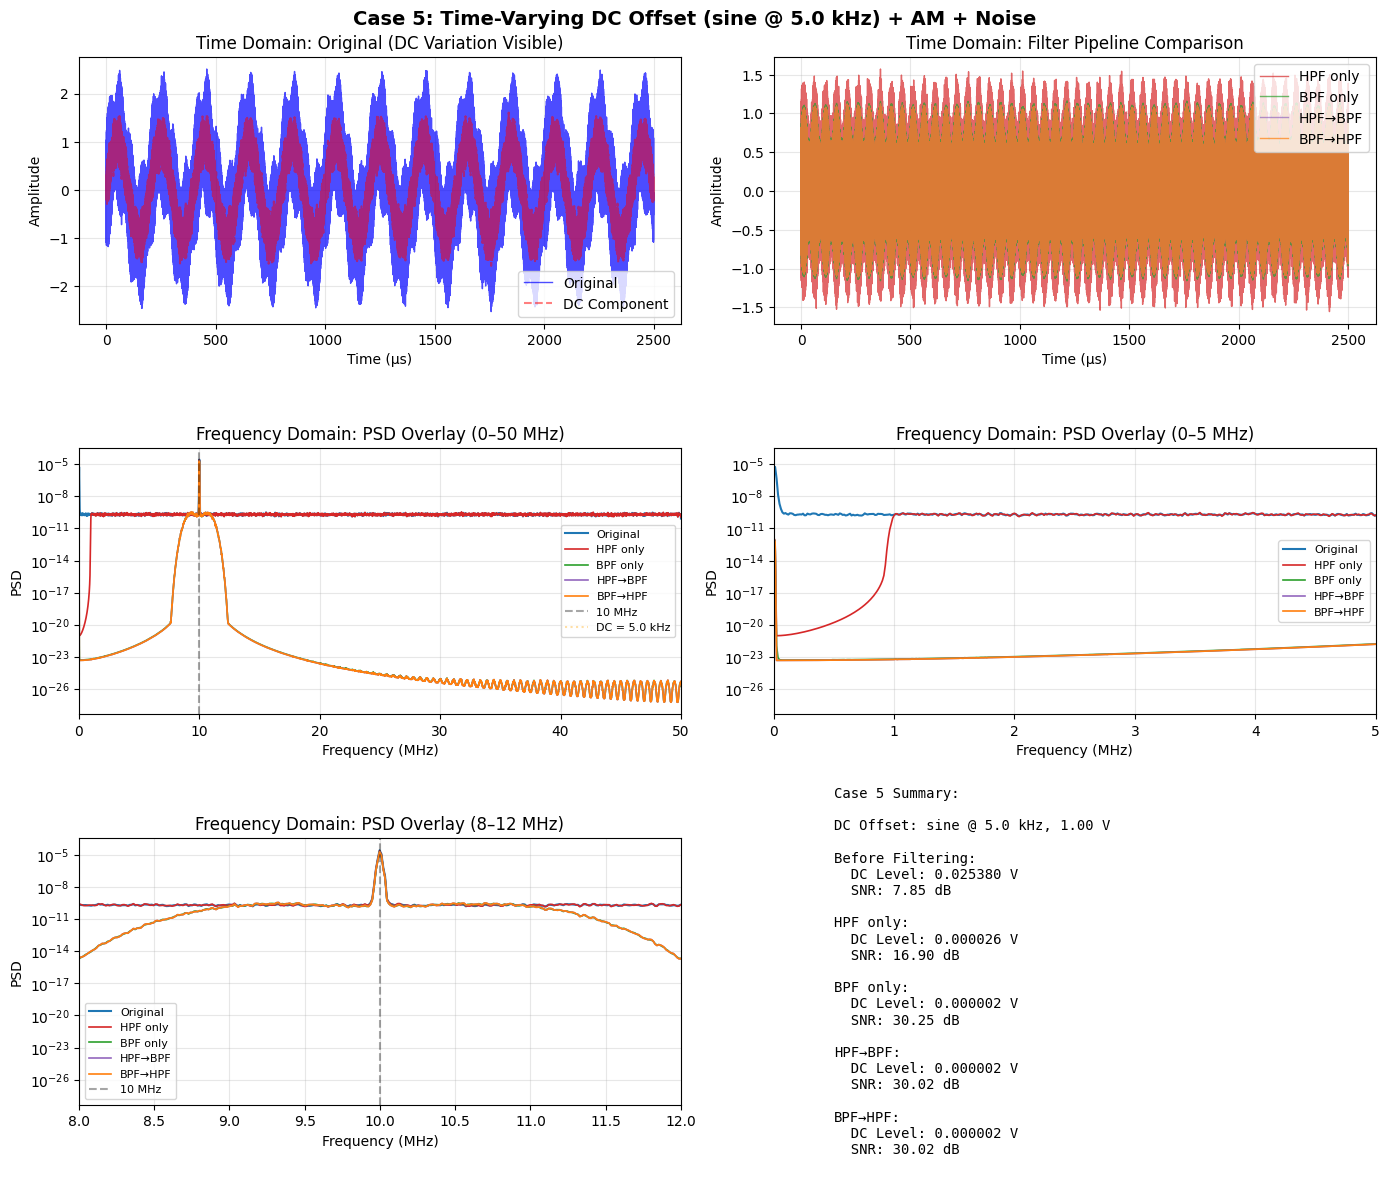

In [14]:
# Visualize Case 5 - Time-varying DC offset
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle(f'Case 5: Time-Varying DC Offset ({dc_offset_waveform} @ {dc_offset_freq/1e3:.1f} kHz) + AM + Noise', fontsize=14, fontweight='bold')

t_us = results_case5['signals']['time'] * 1e6

# Time domain: Original showing DC variation
ax = axes[0, 0]
ax.plot(t_us, results_case5['signals']['original'], 'b-', alpha=0.7, label='Original', linewidth=1)
# Extract DC component for visualization
dc_component = results_case5['signals']['original'] - np.sin(2 * np.pi * f0 * results_case5['signals']['time'])
ax.plot(t_us, dc_component, 'r--', alpha=0.5, linewidth=1.5, label='DC Component')
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Original (DC Variation Visible)')
ax.legend()
ax.grid(True, alpha=0.3)

# Time domain: pipelines
ax = axes[0, 1]
ax.plot(t_us, results_case5['signals']['hpf_filtered'], color='C3', alpha=0.7, label='HPF only', linewidth=1)
ax.plot(t_us, results_case5['signals']['bpf_only'], color='C2', alpha=0.7, label='BPF only', linewidth=1)
ax.plot(t_us, results_case5['signals']['bpf_filtered'], color='C4', alpha=0.7, label='HPF→BPF', linewidth=1)
ax.plot(t_us, results_case5['signals']['bpf_hpf'], color='C1', alpha=0.7, label='BPF→HPF', linewidth=1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Filter Pipeline Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Frequency domain: PSD overlay (full)
ax = axes[1, 0]
freqs_mhz = results_case5['before']['freqs'] / 1e6
ax.semilogy(freqs_mhz, results_case5['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case5['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case5['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case5['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case5['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (0–50 MHz)')
ax.set_xlim(0, 50)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.axvline(dc_offset_freq/1e6, color='orange', linestyle=':', alpha=0.35, label=f'DC = {dc_offset_freq/1e3:.1f} kHz')
ax.legend(fontsize=8)

# Frequency domain: PSD overlay (zoom low frequency / DC)
ax = axes[1, 1]
ax.semilogy(freqs_mhz, results_case5['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case5['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case5['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case5['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case5['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (0–5 MHz)')
ax.set_xlim(0, 5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Frequency domain: PSD overlay (zoom near carrier)
ax = axes[2, 0]
ax.semilogy(freqs_mhz, results_case5['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case5['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case5['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case5['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case5['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (8–12 MHz)')
ax.set_xlim(8, 12)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.legend(fontsize=8)

# Summary statistics
ax = axes[2, 1]
ax.axis('off')
summary_text = f"""
Case 5 Summary:

DC Offset: {dc_offset_waveform} @ {dc_offset_freq/1e3:.1f} kHz, {dc_offset_amplitude:.2f} V

Before Filtering:
  DC Level: {results_case5['before']['dc_level']:.6f} V
  SNR: {results_case5['before']['snr_db']:.2f} dB

HPF only:
  DC Level: {results_case5['after_hpf_only']['dc_level']:.6f} V
  SNR: {results_case5['after_hpf_only']['snr_db']:.2f} dB

BPF only:
  DC Level: {results_case5['after_bpf_only']['dc_level']:.6f} V
  SNR: {results_case5['after_bpf_only']['snr_db']:.2f} dB

HPF→BPF:
  DC Level: {results_case5['after_bpf']['dc_level']:.6f} V
  SNR: {results_case5['after_bpf']['snr_db']:.2f} dB

BPF→HPF:
  DC Level: {results_case5['after_bpf_hpf']['dc_level']:.6f} V
  SNR: {results_case5['after_bpf_hpf']['snr_db']:.2f} dB
"""
ax.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
        verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()


## Case 4: DC Offset + AM Modulation + Random Noise

Full test case with DC offset, AM modulation, and random noise. This tests both HPF (DC removal) and BPF (noise removal).

In [15]:
# Generate and test Case 4
case = 4
t, signal1, signal2 = generate_test_signals(
    fs=fs,
    duration=duration,
    f0=f0,
    case=4,
    dc_offset=dc_offset if case >= 4 else 0.0,
    noise_level=noise_level if case >= 3 else 0.0,
    am_freq=am_freq,
    am_depth=am_depth,
)

# Analyze original signal
analysis_before = analyze_signal_components(signal2, fs, f0)

# Apply highpass filter
hpf_taps = create_highpass_filter(hpf_cutoff, fs)
signal_hpf = spsig.filtfilt(hpf_taps, 1.0, signal2)

analysis_after_hpf = analyze_signal_components(signal_hpf, fs, f0)
analysis_after_hpf_only = analysis_after_hpf  # HPF only

# Apply bandpass filter
phase_converter = PhaseConverter()
bpf_taps = phase_converter._create_bpf(
    f_stop1=f0 - bpf_bandwidth - 0.5e6,
    f_pass1=f0 - bpf_bandwidth / 2,
    f_pass2=f0 + bpf_bandwidth / 2,
    f_stop2=f0 + bpf_bandwidth + 0.5e6,
    fs=fs,
)
# HPF -> BPF
signal_bpf = spsig.filtfilt(bpf_taps, 1.0, signal_hpf)
analysis_after_bpf = analyze_signal_components(signal_bpf, fs, f0)

# BPF only
signal_bpf_only = spsig.filtfilt(bpf_taps, 1.0, signal2)
analysis_after_bpf_only = analyze_signal_components(signal_bpf_only, fs, f0)

# BPF -> HPF
signal_bpf_hpf = spsig.filtfilt(hpf_taps, 1.0, signal_bpf_only)
analysis_after_bpf_hpf = analyze_signal_components(signal_bpf_hpf, fs, f0)

results_case4 = {
    'case': case,
    'before': analysis_before,
    'after_hpf': analysis_after_hpf,
    'after_hpf_only': analysis_after_hpf_only,
    'after_bpf': analysis_after_bpf,
    'after_bpf_only': analysis_after_bpf_only,
    'after_bpf_hpf': analysis_after_bpf_hpf,
    'signals': {
        'time': t,
        'original': signal2,
        'hpf_filtered': signal_hpf,    # HPF only
        'bpf_only': signal_bpf_only,    # BPF only
        'bpf_filtered': signal_bpf,     # HPF -> BPF
        'bpf_hpf': signal_bpf_hpf,      # BPF -> HPF
    },
}

print(f"Case {case} Results:")
print(f"  DC Level (before): {analysis_before['dc_level']:.6f} V")
print(f"  DC Level (HPF only): {analysis_after_hpf_only['dc_level']:.6f} V")
print(f"  DC Level (BPF only): {analysis_after_bpf_only['dc_level']:.6f} V")
print(f"  DC Level (HPF->BPF): {analysis_after_bpf['dc_level']:.6f} V")
print(f"  DC Level (BPF->HPF): {analysis_after_bpf_hpf['dc_level']:.6f} V")
print(f"  SNR (before): {analysis_before['snr_db']:.2f} dB")
print(f"  SNR (HPF only): {analysis_after_hpf_only['snr_db']:.2f} dB")
print(f"  SNR (BPF only): {analysis_after_bpf_only['snr_db']:.2f} dB")
print(f"  SNR (HPF->BPF): {analysis_after_bpf['snr_db']:.2f} dB")
print(f"  SNR (BPF->HPF): {analysis_after_bpf_hpf['snr_db']:.2f} dB")

Case 4 Results:
  DC Level (before): 1.000004 V
  DC Level (HPF only): 0.000016 V
  DC Level (BPF only): 0.000001 V
  DC Level (HPF->BPF): 0.000001 V
  DC Level (BPF->HPF): 0.000001 V
  SNR (before): 17.18 dB
  SNR (HPF only): 16.90 dB
  SNR (BPF only): 30.53 dB
  SNR (HPF->BPF): 30.30 dB
  SNR (BPF->HPF): 30.30 dB


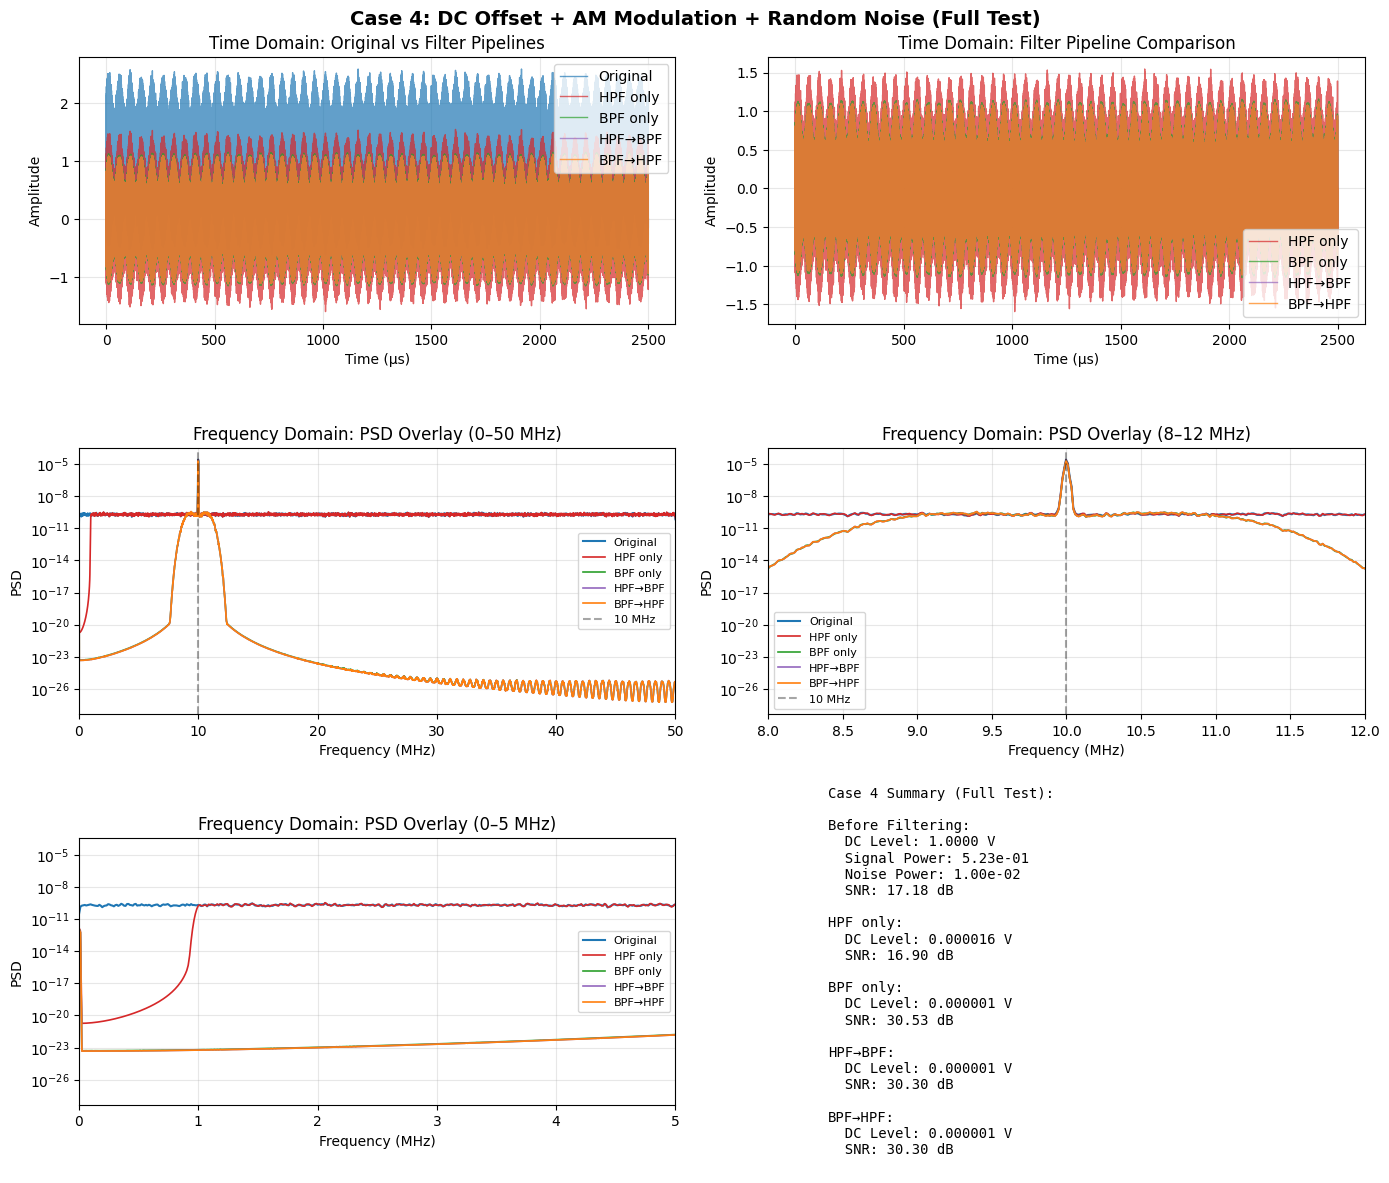

In [16]:
# Visualize Case 4 - Full test case
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle(f'Case 4: DC Offset + AM Modulation + Random Noise (Full Test)', fontsize=14, fontweight='bold')

t_us = results_case4['signals']['time'] * 1e6

# Time domain: Original vs pipelines
ax = axes[0, 0]
ax.plot(t_us, results_case4['signals']['original'], color='C0', alpha=0.7, label='Original', linewidth=1)
ax.plot(t_us, results_case4['signals']['hpf_filtered'], color='C3', alpha=0.7, label='HPF only', linewidth=1)
ax.plot(t_us, results_case4['signals']['bpf_only'], color='C2', alpha=0.7, label='BPF only', linewidth=1)
ax.plot(t_us, results_case4['signals']['bpf_filtered'], color='C4', alpha=0.7, label='HPF→BPF', linewidth=1)
ax.plot(t_us, results_case4['signals']['bpf_hpf'], color='C1', alpha=0.7, label='BPF→HPF', linewidth=1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Original vs Filter Pipelines')
ax.legend()
ax.grid(True, alpha=0.3)

# Time domain: pipelines only
ax = axes[0, 1]
ax.plot(t_us, results_case4['signals']['hpf_filtered'], color='C3', alpha=0.7, label='HPF only', linewidth=1)
ax.plot(t_us, results_case4['signals']['bpf_only'], color='C2', alpha=0.7, label='BPF only', linewidth=1)
ax.plot(t_us, results_case4['signals']['bpf_filtered'], color='C4', alpha=0.7, label='HPF→BPF', linewidth=1)
ax.plot(t_us, results_case4['signals']['bpf_hpf'], color='C1', alpha=0.7, label='BPF→HPF', linewidth=1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Time Domain: Filter Pipeline Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Frequency domain: PSD overlay (full)
ax = axes[1, 0]
freqs_mhz = results_case4['before']['freqs'] / 1e6
ax.semilogy(freqs_mhz, results_case4['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case4['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case4['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case4['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case4['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (0–50 MHz)')
ax.set_xlim(0, 50)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.legend(fontsize=8)

# Frequency domain: PSD overlay (zoom near carrier)
ax = axes[1, 1]
ax.semilogy(freqs_mhz, results_case4['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case4['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case4['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case4['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case4['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (8–12 MHz)')
ax.set_xlim(8, 12)
ax.grid(True, alpha=0.3)
ax.axvline(10, color='k', linestyle='--', alpha=0.35, label='10 MHz')
ax.legend(fontsize=8)

# Frequency domain: PSD overlay (low frequency / DC)
ax = axes[2, 0]
ax.semilogy(freqs_mhz, results_case4['before']['psd'], color='C0', linewidth=1.5, label='Original')
ax.semilogy(freqs_mhz, results_case4['after_hpf_only']['psd'], color='C3', linewidth=1.2, label='HPF only')
ax.semilogy(freqs_mhz, results_case4['after_bpf_only']['psd'], color='C2', linewidth=1.2, label='BPF only')
ax.semilogy(freqs_mhz, results_case4['after_bpf']['psd'], color='C4', linewidth=1.2, label='HPF→BPF')
ax.semilogy(freqs_mhz, results_case4['after_bpf_hpf']['psd'], color='C1', linewidth=1.2, label='BPF→HPF')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD')
ax.set_title('Frequency Domain: PSD Overlay (0–5 MHz)')
ax.set_xlim(0, 5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Summary statistics
ax = axes[2, 1]
ax.axis('off')
dc_reduction = abs(results_case4['before']['dc_level']) - abs(results_case4['after_hpf']['dc_level'])
snr_improvement = results_case4['after_bpf']['snr_db'] - results_case4['before']['snr_db']
summary_text = f"""
Case 4 Summary (Full Test):

Before Filtering:
  DC Level: {results_case4['before']['dc_level']:.4f} V
  Signal Power: {results_case4['before']['signal_power']:.2e}
  Noise Power: {results_case4['before']['noise_power']:.2e}
  SNR: {results_case4['before']['snr_db']:.2f} dB

HPF only:
  DC Level: {results_case4['after_hpf_only']['dc_level']:.6f} V
  SNR: {results_case4['after_hpf_only']['snr_db']:.2f} dB

BPF only:
  DC Level: {results_case4['after_bpf_only']['dc_level']:.6f} V
  SNR: {results_case4['after_bpf_only']['snr_db']:.2f} dB

HPF→BPF:
  DC Level: {results_case4['after_bpf']['dc_level']:.6f} V
  SNR: {results_case4['after_bpf']['snr_db']:.2f} dB

BPF→HPF:
  DC Level: {results_case4['after_bpf_hpf']['dc_level']:.6f} V
  SNR: {results_case4['after_bpf_hpf']['snr_db']:.2f} dB
"""
ax.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
        verticalalignment='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

## Filter Response Visualization

Visualize the frequency response of the highpass and bandpass filters used in the tests.


## Comparative Analysis: HPF Only vs BPF Only vs HPF+BPF

Compare the effectiveness of HPF only, BPF only, and HPF+BPF combinations across all cases.


## CDM Phase-Difference Test (Linear Phase Ramp) — Cases 1–5

This section:

- Assumes a **stable reference** at \(f_0\)
- Synthesizes a **probe** with a **linearly increasing phase difference** (equivalent to a small frequency offset)
- Applies **Case 1–5** impairments to the probe
- Runs **CDM** to recover \(\Delta\phi(t)\)
- Optionally compares **raw** vs **HPF only / BPF only / HPF→BPF / BPF→HPF** (filters applied to both signals via `filtfilt`)



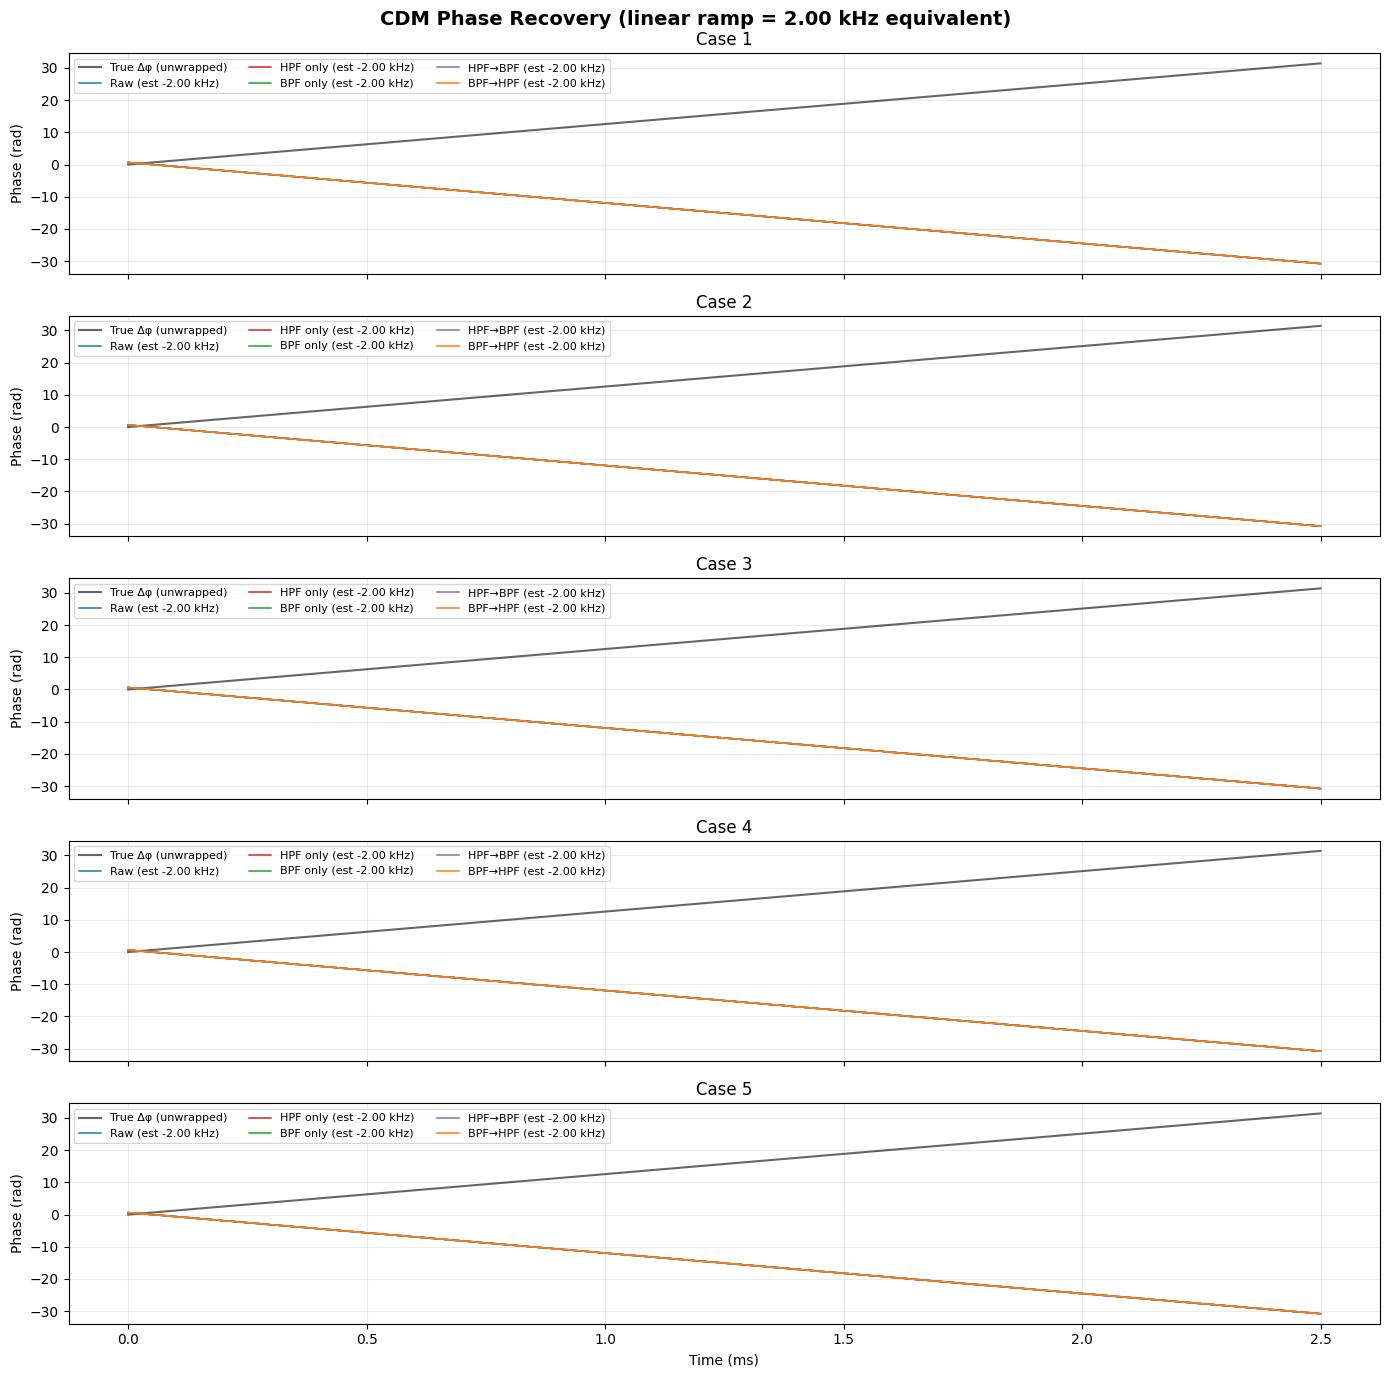


CDM linear phase-ramp recovery summary
Case  Pipeline   Ramp_true(kHz) Ramp_est(kHz) Err(Hz)    RMSE(rad) 
--------------------------------------------------------------------------------------------------------------
1     raw        2.000          -2.000        -4000.00   0.000     
1     hpf_only   2.000          -2.000        -3999.99   0.000     
1     bpf_only   2.000          -2.000        -4000.00   0.000     
1     hpf_to_bpf 2.000          -2.000        -3999.99   0.000     
1     bpf_to_hpf 2.000          -2.000        -3999.99   0.000     
2     raw        2.000          -2.000        -4000.00   0.000     
2     hpf_only   2.000          -2.000        -3999.99   0.013     
2     bpf_only   2.000          -2.000        -4000.00   0.000     
2     hpf_to_bpf 2.000          -2.000        -3999.99   0.013     
2     bpf_to_hpf 2.000          -2.000        -3999.99   0.013     
3     raw        2.000          -2.000        -3999.86   0.016     
3     hpf_only   2.000          -

In [17]:
# CDM phase-difference recovery with a linear phase ramp probe across Case 1–5.

from dataclasses import dataclass


@dataclass(frozen=True)
class CdmRunResult:
    case: int
    pipeline: str
    phase_ramp_hz_true: float
    phase_ramp_hz_est: float
    phase_offset_est_rad: float
    rmse_rad: float
    phase: np.ndarray


def _dc_waveform(t: np.ndarray, *, waveform: str, freq_hz: float, amplitude: float, duration_s: float) -> np.ndarray:
    """Create a time-varying DC offset waveform."""
    if waveform == 'sine':
        return amplitude * np.sin(2 * np.pi * freq_hz * t)
    if waveform == 'triangle':
        return amplitude * spsig.sawtooth(2 * np.pi * freq_hz * t, 0.5)
    if waveform == 'square':
        return amplitude * spsig.square(2 * np.pi * freq_hz * t)
    if waveform == 'chirp':
        return amplitude * np.sin(2 * np.pi * (freq_hz * t + freq_hz * t**2 / max(duration_s, 1e-12)))
    # default
    return amplitude * np.sin(2 * np.pi * freq_hz * t)


def generate_reference_and_probe_linear_phase(
    *,
    fs: float,
    duration: float,
    f0: float,
    phase_ramp_hz: float,
    initial_phase_rad: float,
    case: int,
    dc_offset: float,
    noise_level: float,
    am_freq: float,
    am_depth: float,
    dc_offset_waveform: str,
    dc_offset_freq: float,
    dc_offset_amplitude: float,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Generate stable reference and a probe with linear phase drift + Case 1–5 impairments.

    Returns:
        t: time array
        ref: stable reference (clean)
        probe: impaired probe
        true_phase: ground-truth phase difference (unwrapped)
    """
    t = np.arange(0, duration, 1.0 / fs)
    ref = np.sin(2 * np.pi * f0 * t)

    true_phase = initial_phase_rad + 2 * np.pi * phase_ramp_hz * t
    probe = np.sin(2 * np.pi * f0 * t + true_phase)

    # Case >= 2: AM
    if case >= 2:
        am_env = 1.0 + am_depth * np.sin(2 * np.pi * am_freq * t)
        probe = probe * am_env

    # Case >= 3: noise
    if case >= 3:
        probe = probe + np.random.normal(0.0, noise_level, size=t.shape)

    # Case == 4: constant DC
    if case == 4:
        probe = probe + dc_offset

    # Case == 5: time-varying DC
    if case == 5:
        probe = probe + _dc_waveform(
            t,
            waveform=dc_offset_waveform,
            freq_hz=dc_offset_freq,
            amplitude=dc_offset_amplitude,
            duration_s=duration,
        )

    return t, ref, probe, true_phase


def _apply_pipeline_pair(
    *,
    ref: np.ndarray,
    probe: np.ndarray,
    pipeline: str,
    hpf_taps: np.ndarray,
    bpf_taps: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """Apply a named zero-phase filter pipeline to BOTH ref and probe."""
    if pipeline == 'raw':
        return ref, probe

    if pipeline == 'hpf_only':
        return (
            spsig.filtfilt(hpf_taps, 1.0, ref),
            spsig.filtfilt(hpf_taps, 1.0, probe),
        )

    if pipeline == 'bpf_only':
        return (
            spsig.filtfilt(bpf_taps, 1.0, ref),
            spsig.filtfilt(bpf_taps, 1.0, probe),
        )

    if pipeline == 'hpf_to_bpf':
        ref_h = spsig.filtfilt(hpf_taps, 1.0, ref)
        probe_h = spsig.filtfilt(hpf_taps, 1.0, probe)
        return (
            spsig.filtfilt(bpf_taps, 1.0, ref_h),
            spsig.filtfilt(bpf_taps, 1.0, probe_h),
        )

    if pipeline == 'bpf_to_hpf':
        ref_b = spsig.filtfilt(bpf_taps, 1.0, ref)
        probe_b = spsig.filtfilt(bpf_taps, 1.0, probe)
        return (
            spsig.filtfilt(hpf_taps, 1.0, ref_b),
            spsig.filtfilt(hpf_taps, 1.0, probe_b),
        )

    raise ValueError(f"Unknown pipeline: {pipeline}")


def _estimate_ramp_hz(t: np.ndarray, phase: np.ndarray) -> tuple[float, float]:
    """Estimate linear phase ramp slope in Hz and intercept in rad via least squares."""
    # Fit phase ~ a*t + b
    a, b = np.polyfit(t, phase, 1)
    return float(a / (2 * np.pi)), float(b)


# --- Parameters for CDM test ---
phase_ramp_hz = 2e3            # 2 kHz equivalent frequency offset => linear phase drift
initial_phase_rad = 0.0
pipelines = ['raw', 'hpf_only', 'bpf_only', 'hpf_to_bpf', 'bpf_to_hpf']

# Defaults (in case this section is run without executing Case 5 cells)
_dc_waveform_name = globals().get('dc_offset_waveform', 'sine')
_dc_waveform_freq = float(globals().get('dc_offset_freq', 5e3))
_dc_waveform_amp = float(globals().get('dc_offset_amplitude', 1.0))

# Build taps once
hpf_taps = create_highpass_filter(hpf_cutoff, fs)
phase_converter = PhaseConverter()
bpf_taps = phase_converter._create_bpf(
    f_stop1=f0 - bpf_bandwidth - 0.5e6,
    f_pass1=f0 - bpf_bandwidth / 2,
    f_pass2=f0 + bpf_bandwidth / 2,
    f_stop2=f0 + bpf_bandwidth + 0.5e6,
    fs=fs,
)

cdm_results: list[CdmRunResult] = []

for case in [1, 2, 3, 4, 5]:
    t, ref, probe, true_phase = generate_reference_and_probe_linear_phase(
        fs=fs,
        duration=duration,
        f0=f0,
        phase_ramp_hz=phase_ramp_hz,
        initial_phase_rad=initial_phase_rad,
        case=case,
        dc_offset=dc_offset,
        noise_level=noise_level,
        am_freq=am_freq,
        am_depth=am_depth,
        dc_offset_waveform=_dc_waveform_name if case == 5 else 'sine',
        dc_offset_freq=_dc_waveform_freq if case == 5 else 5e3,
        dc_offset_amplitude=_dc_waveform_amp if case == 5 else 1.0,
    )

    for pipeline in pipelines:
        ref_p, probe_p = _apply_pipeline_pair(
            ref=ref,
            probe=probe,
            pipeline=pipeline,
            hpf_taps=hpf_taps,
            bpf_taps=bpf_taps,
        )

        phase_est, _ = phase_converter.calc_phase_cdm(ref_p, probe_p, fs=fs, f_center=f0)

        ramp_hz_est, phase0_est = _estimate_ramp_hz(t, phase_est)
        phase_fit = 2 * np.pi * ramp_hz_est * t + phase0_est
        rmse = float(np.sqrt(np.mean((phase_est - phase_fit) ** 2)))

        cdm_results.append(
            CdmRunResult(
                case=case,
                pipeline=pipeline,
                phase_ramp_hz_true=phase_ramp_hz,
                phase_ramp_hz_est=ramp_hz_est,
                phase_offset_est_rad=phase0_est,
                rmse_rad=rmse,
                phase=phase_est,
            )
        )

# --- Plot per-case phase recovery ---
label_map = {
    'raw': 'Raw',
    'hpf_only': 'HPF only',
    'bpf_only': 'BPF only',
    'hpf_to_bpf': 'HPF→BPF',
    'bpf_to_hpf': 'BPF→HPF',
}
color_map = {
    'raw': 'C0',
    'hpf_only': 'C3',
    'bpf_only': 'C2',
    'hpf_to_bpf': 'C4',
    'bpf_to_hpf': 'C1',
}

fig, axes = plt.subplots(5, 1, figsize=(14, 14), sharex=True)
fig.suptitle(f"CDM Phase Recovery (linear ramp = {phase_ramp_hz/1e3:.2f} kHz equivalent)", fontsize=14, fontweight='bold')

for ax_i, case in enumerate([1, 2, 3, 4, 5]):
    ax = axes[ax_i]
    ax.plot(t * 1e3, true_phase, color='k', linewidth=1.5, alpha=0.6, label='True Δφ (unwrapped)')

    for pipeline in pipelines:
        r = next(rr for rr in cdm_results if rr.case == case and rr.pipeline == pipeline)
        ax.plot(t * 1e3, r.phase, color=color_map[pipeline], linewidth=1.1, label=f"{label_map[pipeline]} (est {r.phase_ramp_hz_est/1e3:.2f} kHz)")

    ax.set_ylabel('Phase (rad)')
    ax.set_title(f"Case {case}")
    ax.grid(True, alpha=0.25)
    ax.legend(ncol=3, fontsize=8)

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# --- Compact numeric summary (per case/pipeline) ---
print("\n" + "=" * 110)
print("CDM linear phase-ramp recovery summary")
print("=" * 110)
print(f"{'Case':<5} {'Pipeline':<10} {'Ramp_true(kHz)':<14} {'Ramp_est(kHz)':<13} {'Err(Hz)':<10} {'RMSE(rad)':<10}")
print("-" * 110)
for case in [1, 2, 3, 4, 5]:
    for pipeline in pipelines:
        r = next(rr for rr in cdm_results if rr.case == case and rr.pipeline == pipeline)
        err_hz = r.phase_ramp_hz_est - r.phase_ramp_hz_true
        print(f"{case:<5} {pipeline:<10} {r.phase_ramp_hz_true/1e3:<14.3f} {r.phase_ramp_hz_est/1e3:<13.3f} {err_hz:<10.2f} {r.rmse_rad:<10.3f}")
print("=" * 110)



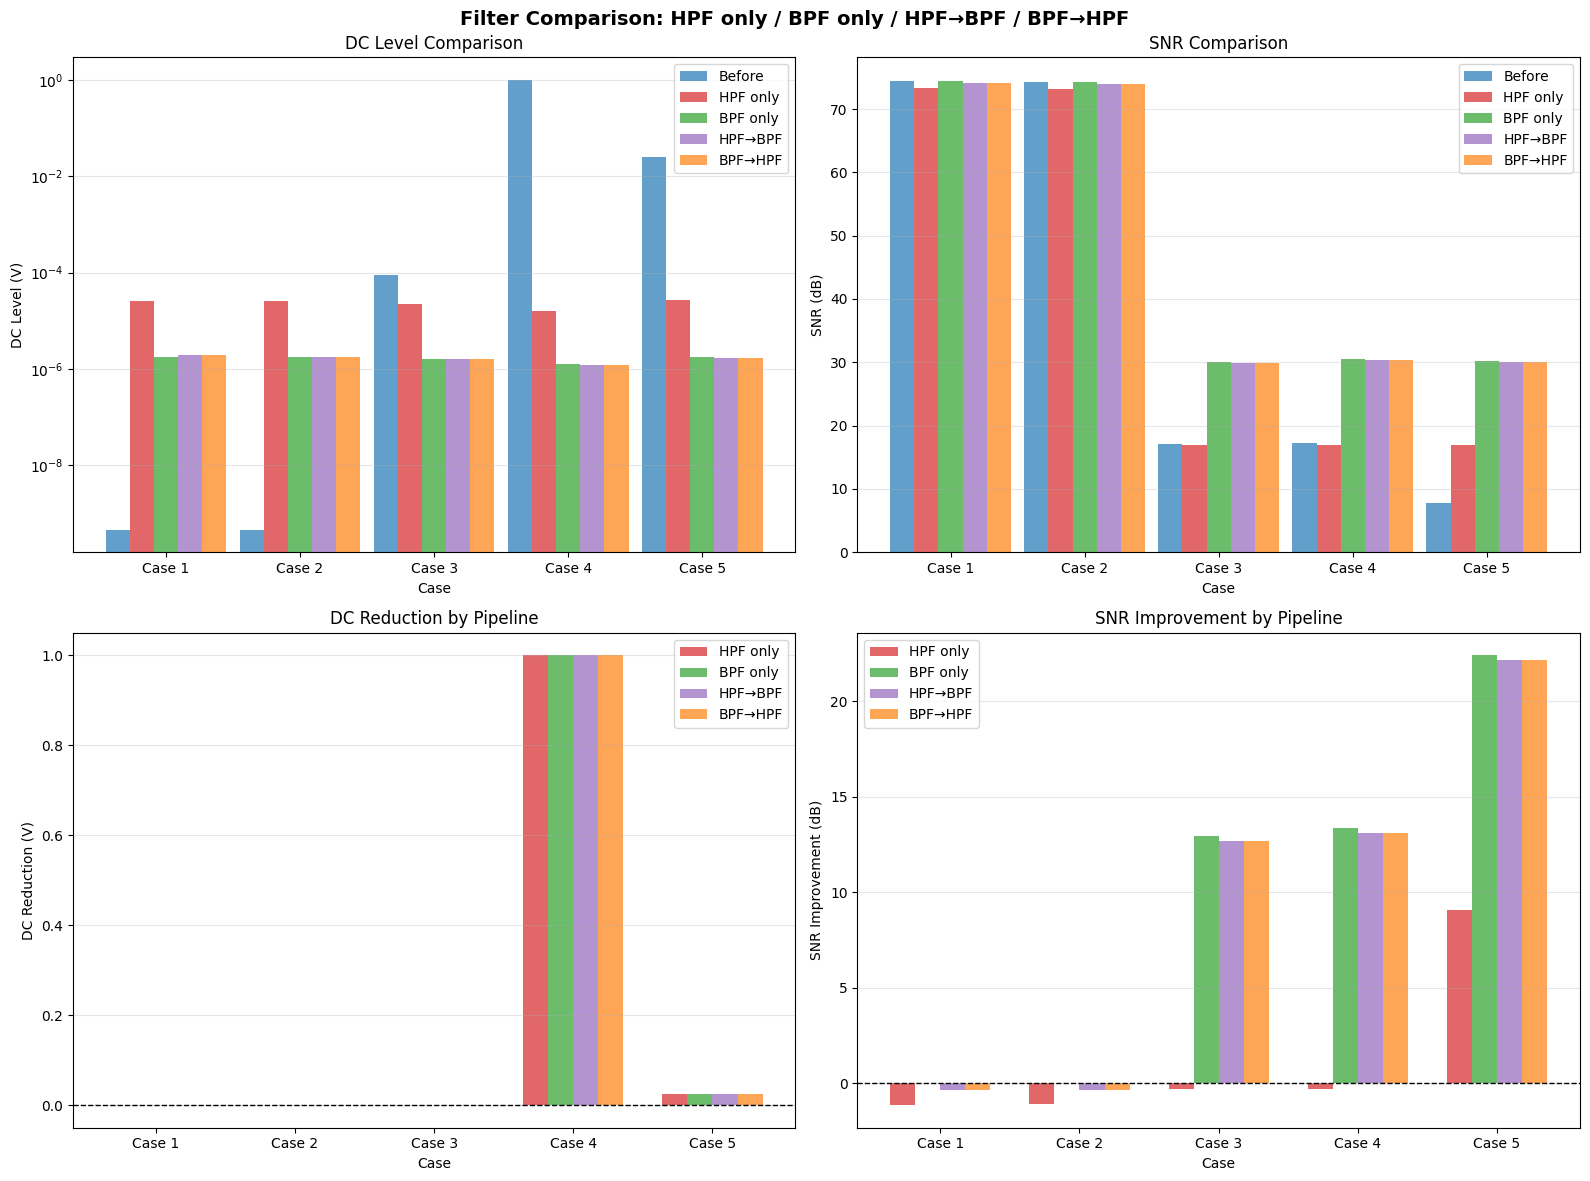

In [18]:
# Comparative analysis: HPF Only vs BPF Only vs HPF+BPF
# Collect all results (ensure all cases are included)
all_results = [results_case1, results_case2, results_case3, results_case4, results_case5]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Filter Comparison: HPF only / BPF only / HPF→BPF / BPF→HPF', fontsize=14, fontweight='bold')

cases = [r['case'] for r in all_results]
x = np.arange(len(cases))
width = 0.18

# DC Level Comparison
ax = axes[0, 0]
dc_before = [abs(r['before']['dc_level']) for r in all_results]
dc_hpf_only = [abs(r['after_hpf_only']['dc_level']) for r in all_results]
dc_bpf_only = [abs(r['after_bpf_only']['dc_level']) for r in all_results]
dc_hpf_bpf = [abs(r['after_bpf']['dc_level']) for r in all_results]
dc_bpf_hpf = [abs(r['after_bpf_hpf']['dc_level']) for r in all_results]

ax.bar(x - 2*width, dc_before, width, label='Before', color='C0', alpha=0.7)
ax.bar(x - 1*width, dc_hpf_only, width, label='HPF only', color='C3', alpha=0.7)
ax.bar(x + 0*width, dc_bpf_only, width, label='BPF only', color='C2', alpha=0.7)
ax.bar(x + 1*width, dc_hpf_bpf, width, label='HPF→BPF', color='C4', alpha=0.7)
ax.bar(x + 2*width, dc_bpf_hpf, width, label='BPF→HPF', color='C1', alpha=0.7)
ax.set_xlabel('Case')
ax.set_ylabel('DC Level (V)')
ax.set_title('DC Level Comparison')
ax.set_xticks(x)
ax.set_xticklabels([f'Case {c}' for c in cases])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_yscale('log')

# SNR Comparison
ax = axes[0, 1]
snr_before = [r['before']['snr_db'] for r in all_results]
snr_hpf_only = [r['after_hpf_only']['snr_db'] for r in all_results]
snr_bpf_only = [r['after_bpf_only']['snr_db'] for r in all_results]
snr_hpf_bpf = [r['after_bpf']['snr_db'] for r in all_results]
snr_bpf_hpf = [r['after_bpf_hpf']['snr_db'] for r in all_results]

ax.bar(x - 2*width, snr_before, width, label='Before', color='C0', alpha=0.7)
ax.bar(x - 1*width, snr_hpf_only, width, label='HPF only', color='C3', alpha=0.7)
ax.bar(x + 0*width, snr_bpf_only, width, label='BPF only', color='C2', alpha=0.7)
ax.bar(x + 1*width, snr_hpf_bpf, width, label='HPF→BPF', color='C4', alpha=0.7)
ax.bar(x + 2*width, snr_bpf_hpf, width, label='BPF→HPF', color='C1', alpha=0.7)
ax.set_xlabel('Case')
ax.set_ylabel('SNR (dB)')
ax.set_title('SNR Comparison')
ax.set_xticks(x)
ax.set_xticklabels([f'Case {c}' for c in cases])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# DC Reduction Comparison (relative to before)
ax = axes[1, 0]
dc_red_hpf = [abs(r['before']['dc_level']) - abs(r['after_hpf_only']['dc_level']) for r in all_results]
dc_red_bpf = [abs(r['before']['dc_level']) - abs(r['after_bpf_only']['dc_level']) for r in all_results]
dc_red_hpf_bpf = [abs(r['before']['dc_level']) - abs(r['after_bpf']['dc_level']) for r in all_results]
dc_red_bpf_hpf = [abs(r['before']['dc_level']) - abs(r['after_bpf_hpf']['dc_level']) for r in all_results]

ax.bar(x - 1.5*width, dc_red_hpf, width, label='HPF only', color='C3', alpha=0.7)
ax.bar(x - 0.5*width, dc_red_bpf, width, label='BPF only', color='C2', alpha=0.7)
ax.bar(x + 0.5*width, dc_red_hpf_bpf, width, label='HPF→BPF', color='C4', alpha=0.7)
ax.bar(x + 1.5*width, dc_red_bpf_hpf, width, label='BPF→HPF', color='C1', alpha=0.7)
ax.set_xlabel('Case')
ax.set_ylabel('DC Reduction (V)')
ax.set_title('DC Reduction by Pipeline')
ax.set_xticks(x)
ax.set_xticklabels([f'Case {c}' for c in cases])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='k', linestyle='--', linewidth=1)

# SNR Improvement Comparison (relative to before)
ax = axes[1, 1]
snr_imp_hpf = [r['after_hpf_only']['snr_db'] - r['before']['snr_db'] for r in all_results]
snr_imp_bpf = [r['after_bpf_only']['snr_db'] - r['before']['snr_db'] for r in all_results]
snr_imp_hpf_bpf = [r['after_bpf']['snr_db'] - r['before']['snr_db'] for r in all_results]
snr_imp_bpf_hpf = [r['after_bpf_hpf']['snr_db'] - r['before']['snr_db'] for r in all_results]

ax.bar(x - 1.5*width, snr_imp_hpf, width, label='HPF only', color='C3', alpha=0.7)
ax.bar(x - 0.5*width, snr_imp_bpf, width, label='BPF only', color='C2', alpha=0.7)
ax.bar(x + 0.5*width, snr_imp_hpf_bpf, width, label='HPF→BPF', color='C4', alpha=0.7)
ax.bar(x + 1.5*width, snr_imp_bpf_hpf, width, label='BPF→HPF', color='C1', alpha=0.7)
ax.set_xlabel('Case')
ax.set_ylabel('SNR Improvement (dB)')
ax.set_title('SNR Improvement by Pipeline')
ax.set_xticks(x)
ax.set_xticklabels([f'Case {c}' for c in cases])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


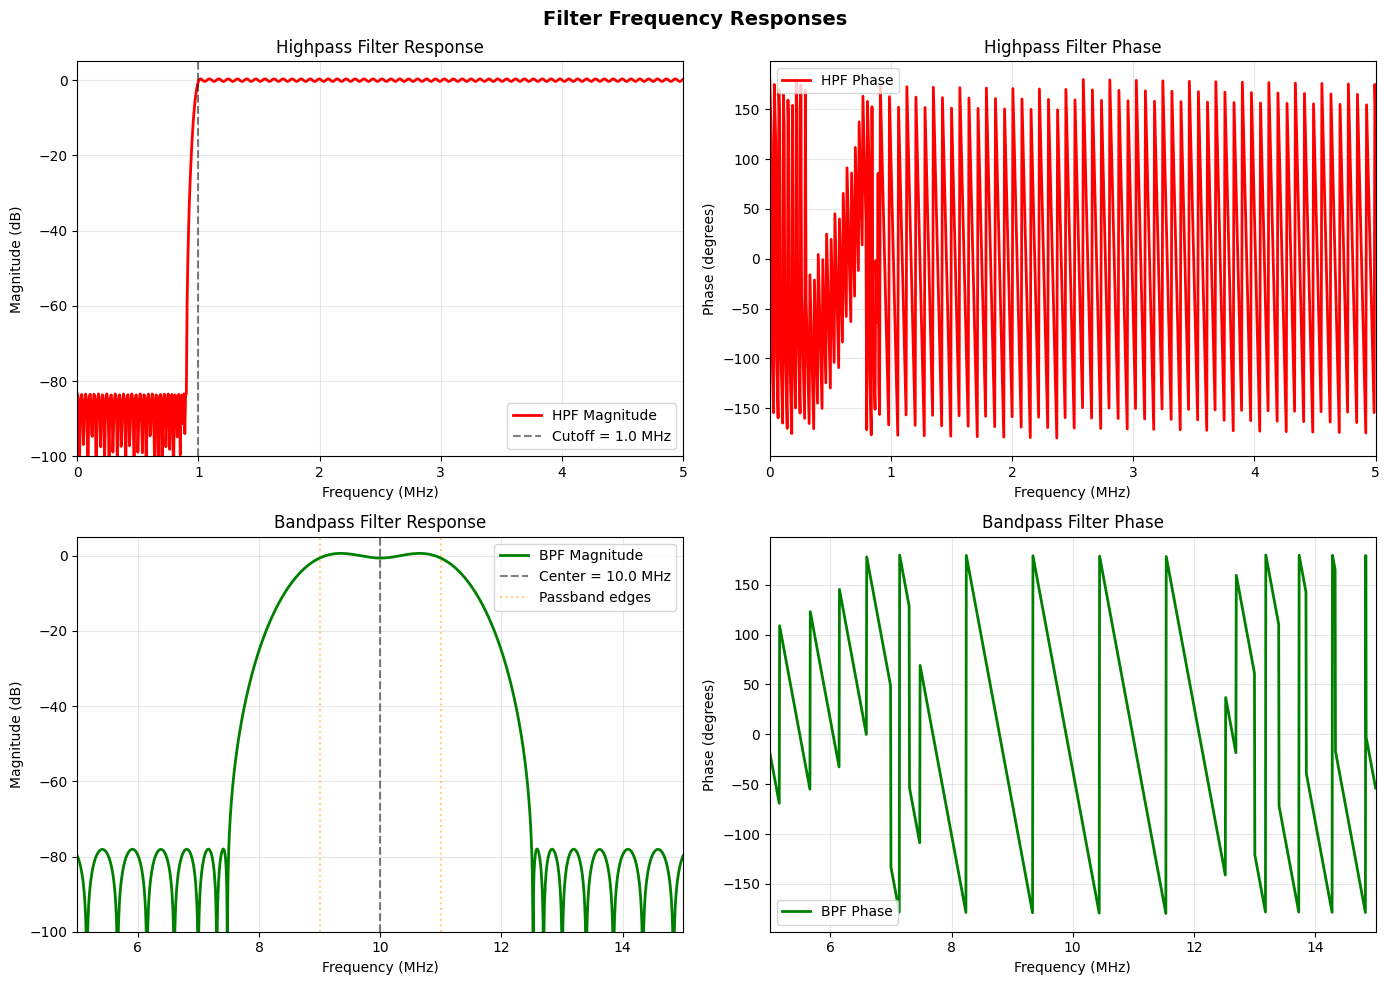

In [19]:
# Visualize filter frequency responses
from scipy.signal import freqz

# Get filter coefficients
hpf_taps = create_highpass_filter(hpf_cutoff, fs)
phase_converter = PhaseConverter()
bpf_taps = phase_converter._create_bpf(
    f_stop1=f0 - bpf_bandwidth - 0.5e6,
    f_pass1=f0 - bpf_bandwidth / 2,
    f_pass2=f0 + bpf_bandwidth / 2,
    f_stop2=f0 + bpf_bandwidth + 0.5e6,
    fs=fs,
)

# Calculate frequency responses
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Filter Frequency Responses', fontsize=14, fontweight='bold')

# Highpass filter response
ax = axes[0, 0]
w_hpf, h_hpf = freqz(hpf_taps, worN=8000, fs=fs)
# Avoid division by zero in log10
h_hpf_mag = np.abs(h_hpf)
h_hpf_mag[h_hpf_mag == 0] = np.finfo(float).eps
ax.plot(w_hpf / 1e6, 20 * np.log10(h_hpf_mag), 'r-', linewidth=2, label='HPF Magnitude')
ax.axvline(hpf_cutoff / 1e6, color='k', linestyle='--', alpha=0.5, label=f'Cutoff = {hpf_cutoff/1e6:.1f} MHz')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Highpass Filter Response')
ax.set_xlim(0, 5)
ax.set_ylim(-100, 5)
ax.grid(True, alpha=0.3)
ax.legend()

# Highpass filter phase
ax = axes[0, 1]
ax.plot(w_hpf / 1e6, np.angle(h_hpf) * 180 / np.pi, 'r-', linewidth=2, label='HPF Phase')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Phase (degrees)')
ax.set_title('Highpass Filter Phase')
ax.set_xlim(0, 5)
ax.grid(True, alpha=0.3)
ax.legend()

# Bandpass filter response
ax = axes[1, 0]
w_bpf, h_bpf = freqz(bpf_taps, worN=8000, fs=fs)
ax.plot(w_bpf / 1e6, 20 * np.log10(np.abs(h_bpf)), 'g-', linewidth=2, label='BPF Magnitude')
ax.axvline(f0 / 1e6, color='k', linestyle='--', alpha=0.5, label=f'Center = {f0/1e6:.1f} MHz')
ax.axvline((f0 - bpf_bandwidth/2) / 1e6, color='orange', linestyle=':', alpha=0.5, label='Passband edges')
ax.axvline((f0 + bpf_bandwidth/2) / 1e6, color='orange', linestyle=':', alpha=0.5)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Bandpass Filter Response')
ax.set_xlim(5, 15)
ax.set_ylim(-100, 5)
ax.grid(True, alpha=0.3)
ax.legend()

# Bandpass filter phase
ax = axes[1, 1]
ax.plot(w_bpf / 1e6, np.angle(h_bpf) * 180 / np.pi, 'g-', linewidth=2, label='BPF Phase')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Phase (degrees)')
ax.set_title('Bandpass Filter Phase')
ax.set_xlim(5, 15)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


## Summary: All Cases Comparison

Compare DC offset removal and SNR improvement across all test cases.

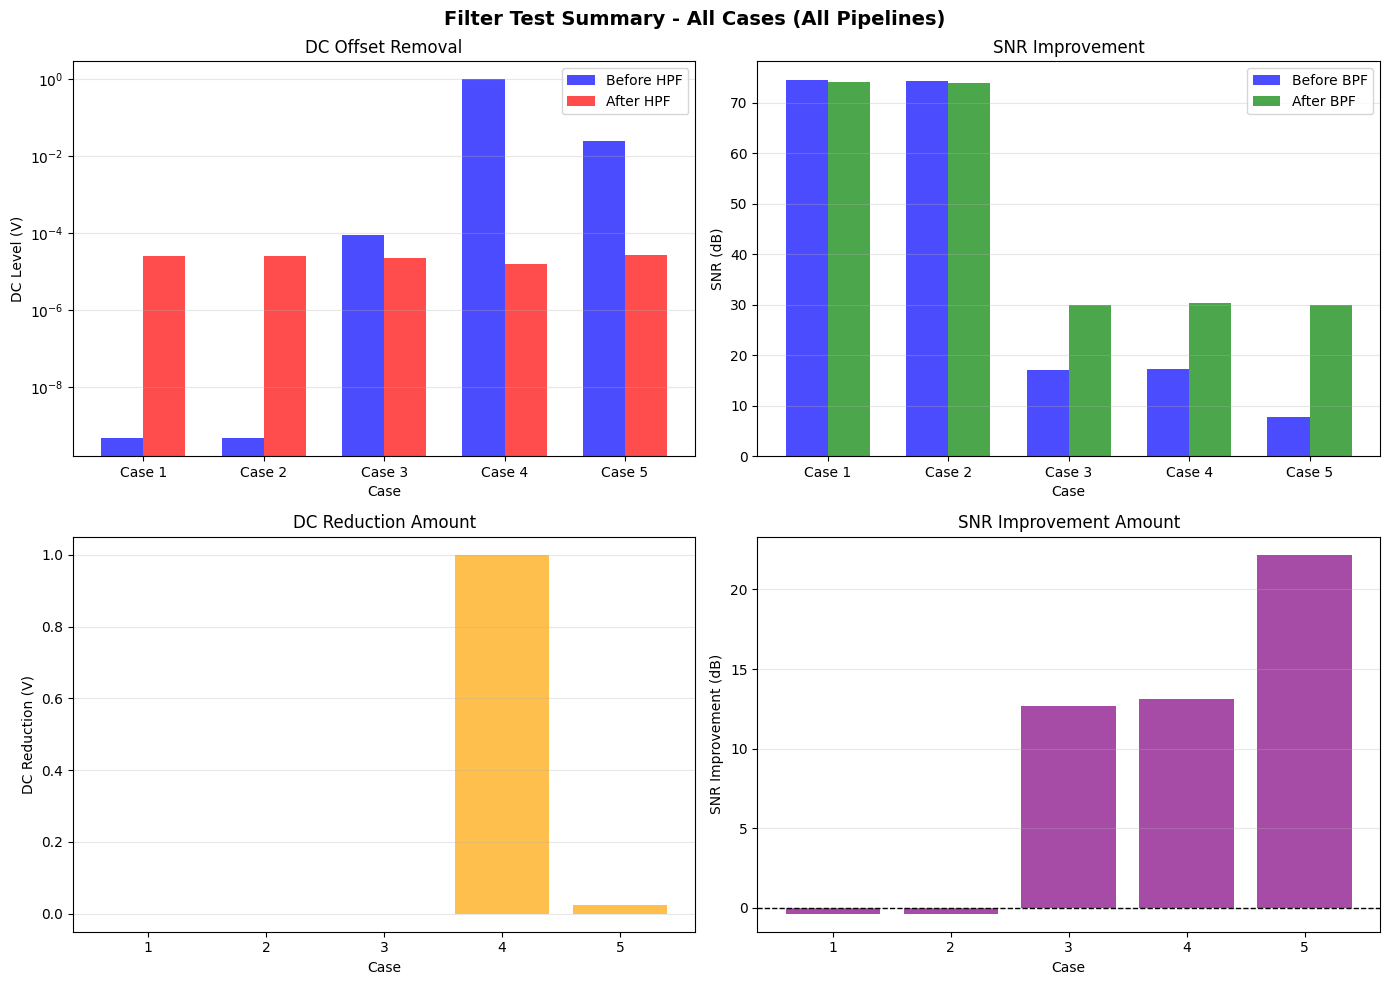


SUMMARY TABLE

PIPELINE SUMMARY TABLE
Case   DC|Before    DC|HPF       DC|BPF       DC|HPF->BPF  DC|BPF->HPF  SNR|Before   SNR|HPF    SNR|BPF    SNR|HPF->BPF SNR|BPF->HPF
--------------------------------------------------------------------------------------------------------------------------------------------
1      0.000000     0.000025     0.000002     0.000002     0.000002     74.44        73.30      74.44      74.09        74.09       
2      0.000000     0.000025     0.000002     0.000002     0.000002     74.29        73.19      74.29      73.92        73.92       
3      0.000090     0.000022     0.000002     0.000002     0.000002     17.15        16.87      30.11      29.84        29.84       
4      1.000004     0.000016     0.000001     0.000001     0.000001     17.18        16.90      30.53      30.30        30.30       
5      0.025380     0.000026     0.000002     0.000002     0.000002     7.85         16.90      30.25      30.02        30.02       
Case   DC Before (V)  

In [ ]:
# Collect all results and create summary plots
all_results = [results_case1, results_case2, results_case3, results_case4, results_case5]

# Create summary comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Filter Test Summary - All Cases (All Pipelines)', fontsize=14, fontweight='bold')

# DC offset removal comparison
ax = axes[0, 0]
cases = [r['case'] for r in all_results]
dc_before = [abs(r['before']['dc_level']) for r in all_results]
dc_after_hpf = [abs(r['after_hpf']['dc_level']) for r in all_results]

x = np.arange(len(cases))
width = 0.35
ax.bar(x - width/2, dc_before, width, label='Before HPF', color='blue', alpha=0.7)
ax.bar(x + width/2, dc_after_hpf, width, label='After HPF', color='red', alpha=0.7)
ax.set_xlabel('Case')
ax.set_ylabel('DC Level (V)')
ax.set_title('DC Offset Removal')
ax.set_xticks(x)
ax.set_xticklabels([f'Case {c}' for c in cases])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_yscale('log')

# SNR comparison
ax = axes[0, 1]
snr_before = [r['before']['snr_db'] for r in all_results]
snr_after_bpf = [r['after_bpf']['snr_db'] for r in all_results]

ax.bar(x - width/2, snr_before, width, label='Before BPF', color='blue', alpha=0.7)
ax.bar(x + width/2, snr_after_bpf, width, label='After BPF', color='green', alpha=0.7)
ax.set_xlabel('Case')
ax.set_ylabel('SNR (dB)')
ax.set_title('SNR Improvement')
ax.set_xticks(x)
ax.set_xticklabels([f'Case {c}' for c in cases])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# DC reduction amount
ax = axes[1, 0]
dc_reductions = [abs(r['before']['dc_level']) - abs(r['after_hpf']['dc_level']) for r in all_results]
ax.bar(cases, dc_reductions, color='orange', alpha=0.7)
ax.set_xlabel('Case')
ax.set_ylabel('DC Reduction (V)')
ax.set_title('DC Reduction Amount')
ax.grid(True, alpha=0.3, axis='y')

# SNR improvement
ax = axes[1, 1]
snr_improvements = [r['after_bpf']['snr_db'] - r['before']['snr_db'] for r in all_results]
ax.bar(cases, snr_improvements, color='purple', alpha=0.7)
ax.set_xlabel('Case')
ax.set_ylabel('SNR Improvement (dB)')
ax.set_title('SNR Improvement Amount')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='k', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)

# Pipeline summary table (HPF only, BPF only, HPF->BPF, BPF->HPF)
print("\n" + "="*140)
print("PIPELINE SUMMARY TABLE")
print("="*140)
print(f"{'Case':<6} {'DC|Before':<12} {'DC|HPF':<12} {'DC|BPF':<12} {'DC|HPF->BPF':<12} {'DC|BPF->HPF':<12} {'SNR|Before':<12} {'SNR|HPF':<10} {'SNR|BPF':<10} {'SNR|HPF->BPF':<12} {'SNR|BPF->HPF':<12}")
print("-"*140)
for r in all_results:
    dc0 = abs(r['before']['dc_level'])
    dch = abs(r['after_hpf_only']['dc_level'])
    dcb = abs(r['after_bpf_only']['dc_level'])
    dchb = abs(r['after_bpf']['dc_level'])
    dcbh = abs(r['after_bpf_hpf']['dc_level'])
    snr0 = r['before']['snr_db']
    snrh = r['after_hpf_only']['snr_db']
    snrb = r['after_bpf_only']['snr_db']
    snrhb = r['after_bpf']['snr_db']
    snrbh = r['after_bpf_hpf']['snr_db']
    print(f"{r['case']:<6} {dc0:<12.6f} {dch:<12.6f} {dcb:<12.6f} {dchb:<12.6f} {dcbh:<12.6f} {snr0:<12.2f} {snrh:<10.2f} {snrb:<10.2f} {snrhb:<12.2f} {snrbh:<12.2f}")
print("="*140)
print(f"{'Case':<6} {'DC Before (V)':<15} {'DC After HPF (V)':<18} {'DC Reduction (V)':<18} {'SNR Before (dB)':<15} {'SNR After (dB)':<15} {'SNR Improvement (dB)':<20}")
print("-"*80)
for r in all_results:
    dc_b = abs(r['before']['dc_level'])
    dc_a = abs(r['after_hpf']['dc_level'])
    dc_red = dc_b - dc_a
    snr_b = r['before']['snr_db']
    snr_a = r['after_bpf']['snr_db']
    snr_imp = snr_a - snr_b
    print(f"{r['case']:<6} {dc_b:<15.6f} {dc_a:<18.6f} {dc_red:<18.6f} {snr_b:<15.2f} {snr_a:<15.2f} {snr_imp:<20.2f}")
print("="*80)